# Projekt z przedmiotu Zaawansowane metody uczenia maszynowego
Autor: Brygida Juszczuk
## Cel projektu

Celem projektu jest opracowanie modelu uczenia maszynowego, który będzie w stanie przewidzieć przyszłe kursy wymiany walut na podstawie historycznych danych dotyczących kursu euro względem innych walut.
## Opis zbioru

Zbiór danych „***euro-daily-hist_1999_2022***” pochodzi ze strony [kaggle.com](https://www.kaggle.com/datasets/lsind18/euro-exchange-daily-rates-19992020). Zbiór danych zawiera historyczne kursy wymiany euro na 40 różnych walut, jednak w ramach projektu zostało wybranych tylko 12 walut. Dane obejmują okres od 4 stycznia 1999 roku do 11 kwietnia 2024 roku. Każdy wiersz reprezentuje kursy walut z danego dnia, a każda kolumna zawiera kurs euro względem jednej z walut.

**Waluty:**

-   `Australian dollar` - dolar australijski,

-   `Czech koruna` - korona czeska,

-   `Danish krone` - korona duńska,

-   `Hong Kong dollar` - dolar hongkoński,

-   `Japanese yen` - jen japoński,

-   `Korean won` - won południowokoreański,

-   `Mexican peso` - peso meksykańskie,

-   `Malaysian ringgit` - ringgit malezyjski,

-   `Philippine peso` - peso filipińskie,

-   `Polish zloty` - złoty polski,

-   `Singapore dollar` - dolar singapurski,

-   `US dollar` - dolar amerykański,

In [1]:
#Wczytanie paczek
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(keras))
suppressPackageStartupMessages(library(tensorflow))
suppressPackageStartupMessages(library(tfdatasets))

Przed przystąpieniem do głównej analizy danych, zbiór danych został wstępnie oczyszczony. W ramach tego procesu zidentyfikowano i usunięto obserwacje zawierające braki danych, co doprowadziło do usunięcia 63 obserwacji. Po dokonaniu oczyszczenia, zbiór został zapisany jako `date.csv` i będzie wykorzystany w dalszej części projektu.

In [2]:
Dataset_clean<-read.csv("/kaggle/input/dataset-clean/date.csv")

In [3]:
colSums(is.na(Dataset_clean))

Data Australian.dollar.      Czech.koruna.      Danish.krone. 
                 0                  0                  0                  0 
 Hong.Kong.dollar.      Japanese.yen.        Korean.won. Malaysian.ringgit. 
                 0                  0                  0                  0 
     Mexican.peso.   Philippine.peso.      Polish.zloty.  Singapore.dollar. 
                 0                  0                  0                  0 
        US.dollar. 
                 0

## Resampling
W zbiorze danych nie występują notowania dla każdego dnia. Aby zapewnić kompletność danych dotyczących notowań walut, zastosowano resampling, czyli technikę modyfikacji częstotliwości próbkowania danych. Głównym celem resamplingu jest przekształcenie danych o nieregularnych odstępach czasowych lub z brakami w danych na jednolite interwały czasowe. Dzięki temu możliwe staje się jednolite reprezentowanie danych w regularnych odstępach czasowych. Takie działanie jest kluczowe dla skutecznego budowania modeli uczenia maszynowego, w tym sieci neuronowych.

In [4]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(imputeTS))

Dataset_clean <- Dataset_clean %>%
  mutate(Data = as.Date(Data))

# Przekształcenie danych w odpowiedni format
Dataset_data <- Dataset_clean %>% 
  pivot_longer(cols = -Data, names_to = "Currency", values_to = "Rate")

# Tworzenie pełnej sekwencji dat
Dataset_data <- Dataset_data %>%
  group_by(Currency) %>%
  complete(Data = seq.Date(min(Data), max(Data), by = "1 day"), fill = list(Rate = NA))

# Użycie algorytmu KNN do imputacji brakujących wartości
Dataset_data <- Dataset_data %>%
  group_by(Currency) %>%
  mutate(Rate = na_kalman(Rate))

# Przywracanie oryginalnego formatu danych
Dataset_clean <- Dataset_data %>%
  pivot_wider(names_from = Currency, values_from = Rate)

## Statystyki opisowe
Poniżej zaprezentowane są podstawowe statystyki opisowe dla każdej z walut.

In [5]:
selected_columns <- Dataset_clean %>% select(-c(1))

summary(selected_columns)

 Australian.dollar. Czech.koruna.   Danish.krone.   Hong.Kong.dollar.
 Min.   :1.164      Min.   :22.97   Min.   :7.423   Min.   : 6.436   
 1st Qu.:1.487      1st Qu.:25.46   1st Qu.:7.439   1st Qu.: 8.465   
 Median :1.600      Median :27.02   Median :7.448   Median : 9.180   
 Mean   :1.580      Mean   :27.95   Mean   :7.448   Mean   : 9.241   
 3rd Qu.:1.668      3rd Qu.:29.99   3rd Qu.:7.458   3rd Qu.:10.152   
 Max.   :2.074      Max.   :38.58   Max.   :7.473   Max.   :12.470   
 Japanese.yen.    Korean.won.     Malaysian.ringgit. Mexican.peso.   
 Min.   : 89.3   Min.   : 938.7   Min.   :3.155      Min.   : 7.624  
 1st Qu.:117.8   1st Qu.:1252.3   1st Qu.:4.131      1st Qu.:13.797  
 Median :129.5   Median :1337.6   Median :4.588      Median :17.011  
 Mean   :129.0   Mean   :1353.2   Mean   :4.442      Mean   :16.755  
 3rd Qu.:137.4   3rd Qu.:1434.7   3rd Qu.:4.780      3rd Qu.:20.326  
 Max.   :169.8   Max.   :1994.0   Max.   :5.186      Max.   :27.090  
 Philippine.peso. Po

Można zauważyć, że największe zróżnicowanie kursowe wśród wymienionych walut występuje dla Mexican Peso, którego maksymalna wartość wynosi 27.090, co jest prawie czterokrotnie wyższe od minimalnej wartości wynoszącej 7.624. Korean Won zmienia się natomiast w zakresie od 938.7 do 1994.0, podczas gdy Philippine Peso oscyluje między 36.84 a 76.76. Te znaczące różnice między ich minimalnymi a maksymalnymi wartościami świadczą o dużym stopniu zmienności tych walut na rynku walutowym.

## Macierz korelacji

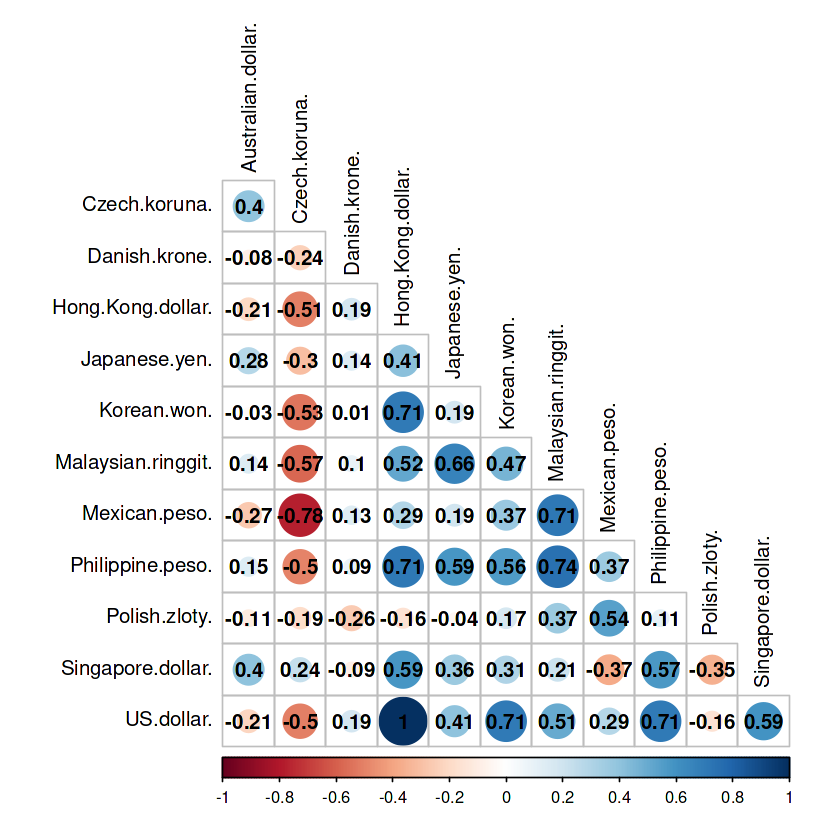

In [6]:
suppressPackageStartupMessages(library(corrplot))

 selected_columns <- Dataset_clean %>% select(-1)

cor_matrix <- cor(selected_columns)

corrplot(cor_matrix, 
         method = "circle",
         type = "lower", 
         order = "original", 
         tl.col = "black", addCoef.col = "black",diag = FALSE)

Macierz korelacji przedstawia współczynniki korelacji między kursami wymiany różnych walut. Ciekawym przypadkiem jest dodatnia korelacja między dolarem amerykańskim a filipińskim peso, z współczynnikiem wynoszącym 0.71. Oznacza to, że te dwie waluty mają tendencję do poruszania się w tym samym kierunku. Z kolei istnieje silna negatywna korelacja między koroną czesnką, a meksykańskim peso, wynosząca -0.78, co sugeruje, że kiedy wartość jednej waluty rośnie, druga spada.

Warto również zauważyć, że dolar amerykański i koreański won są ze sobą silnie powiązane, z dodatnią korelacją wynoszącą 0.71. Co ciekawe, istnieje dodatnia korelacja pomiędzy dolarem amerykańskim a dolarem hongkońskim wynosząca 1, co oznacza, że zmiany wartości tych walut są doskonale skorelowane.

## Wizualizacje

Przedstawione wykresy ukazują zmiany wartości poszczególnych walut w czasie.

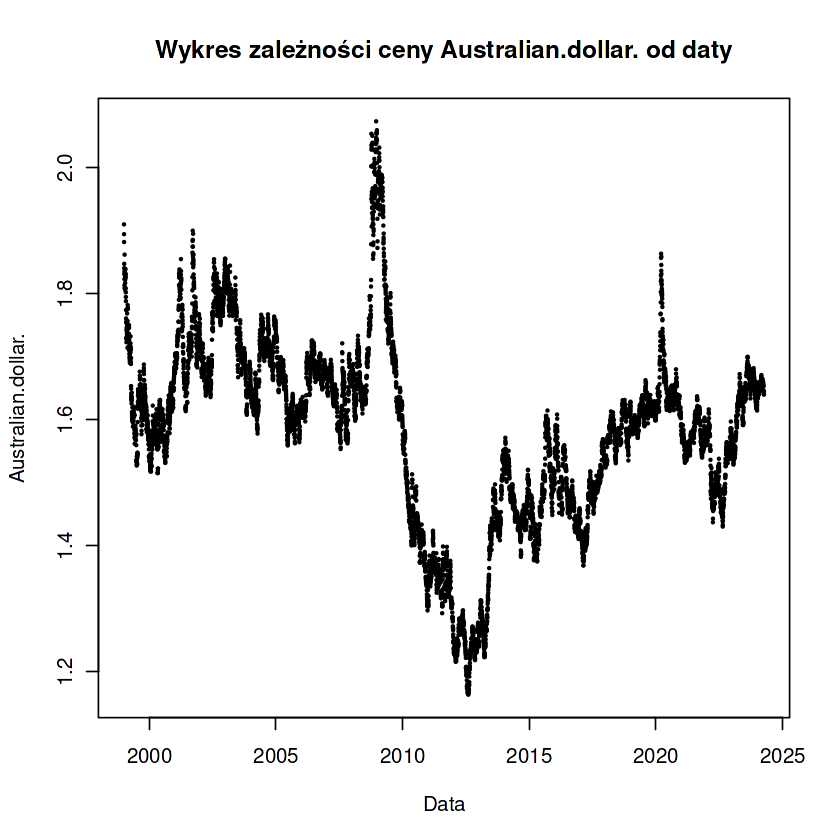

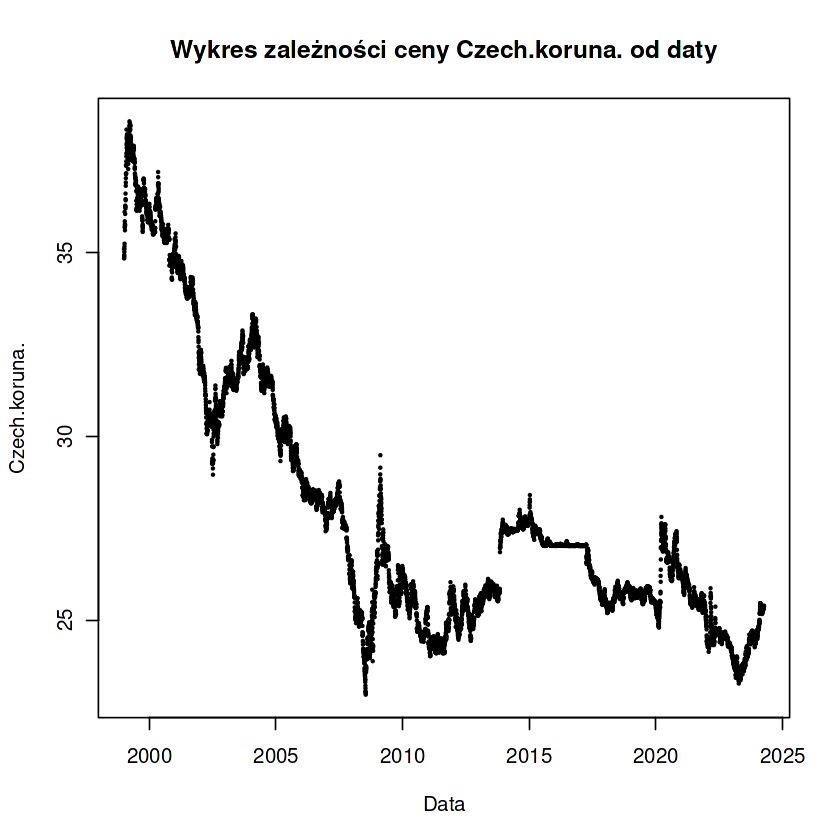

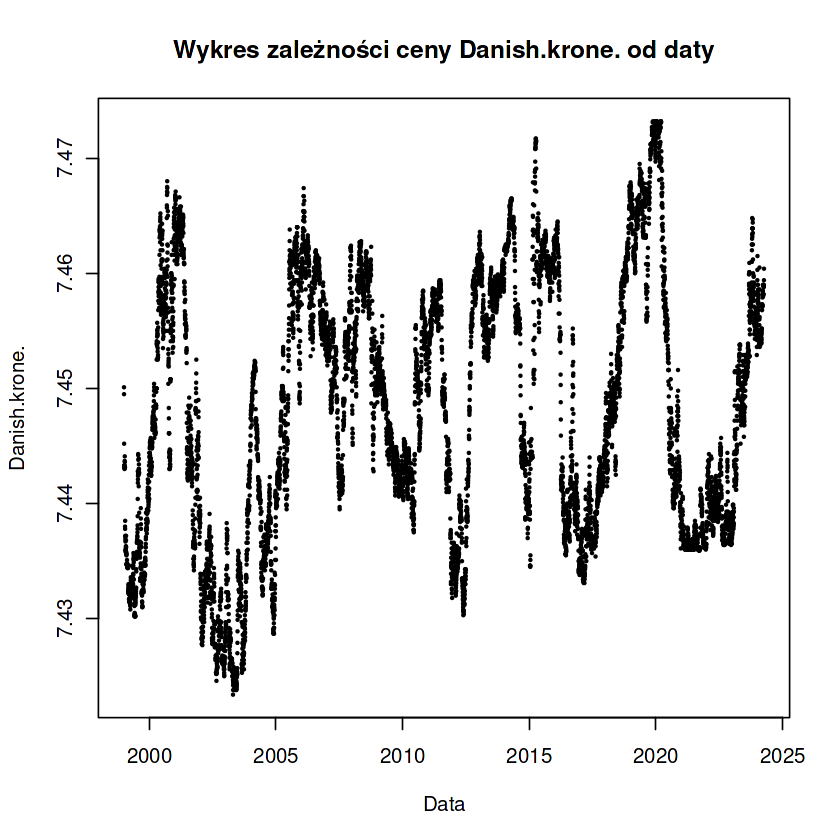

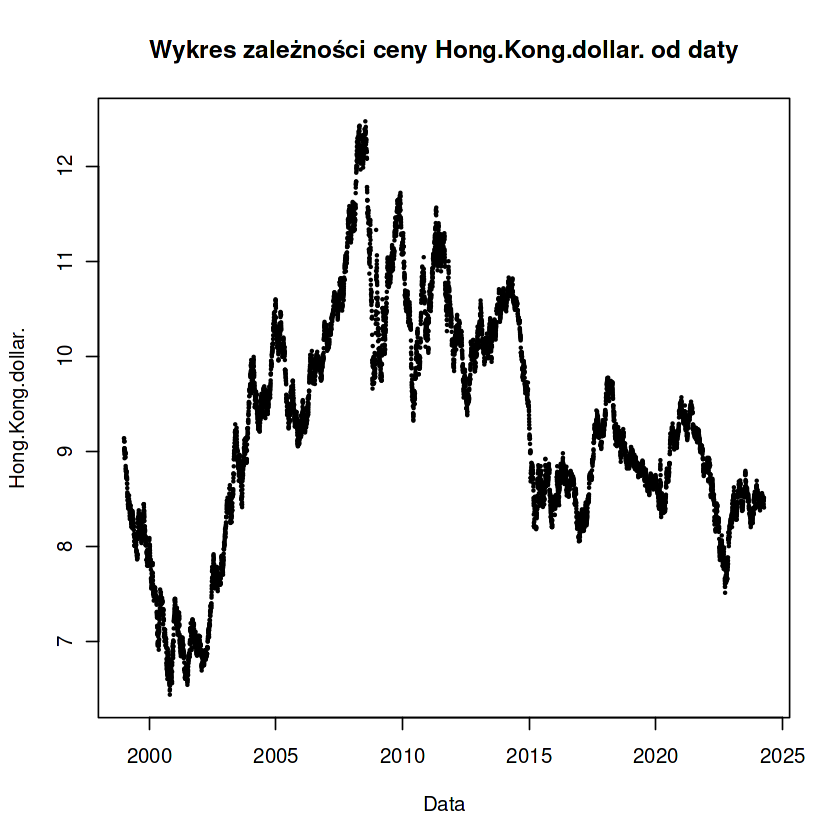

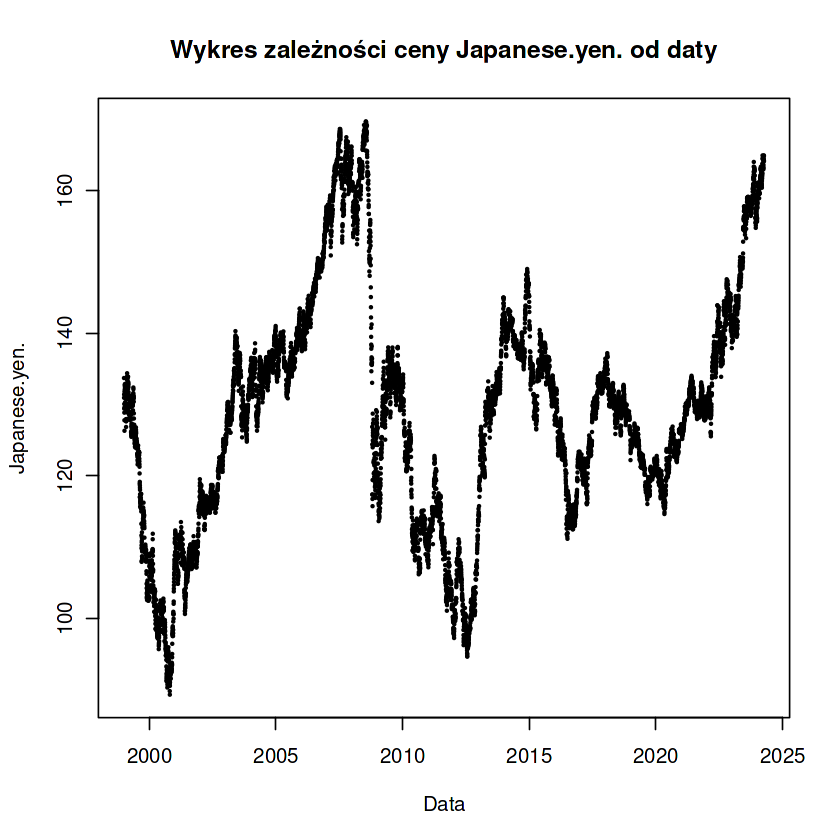

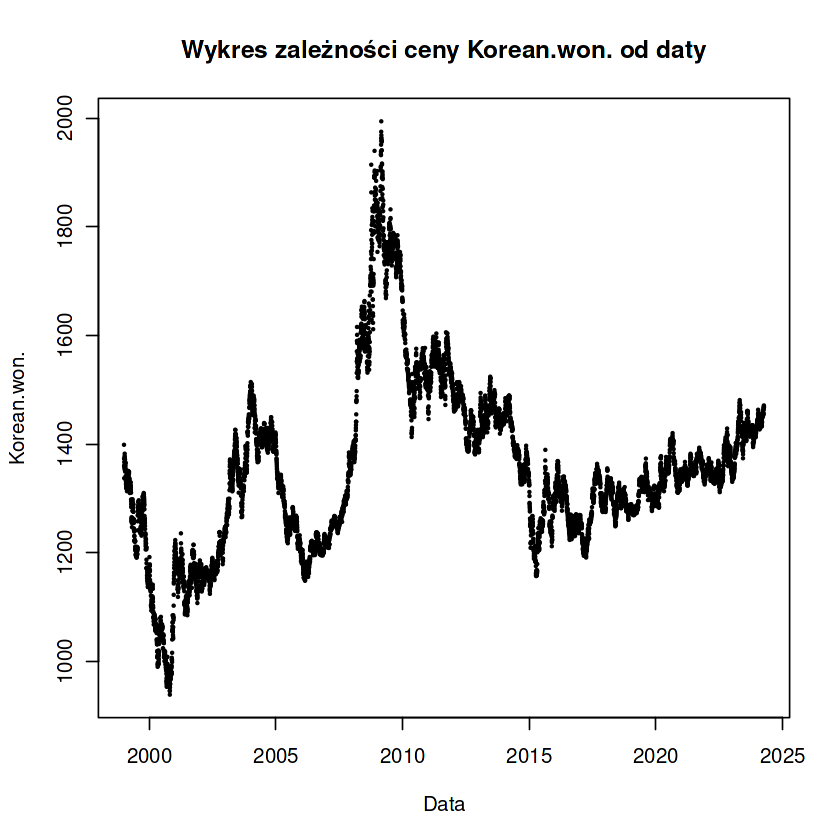

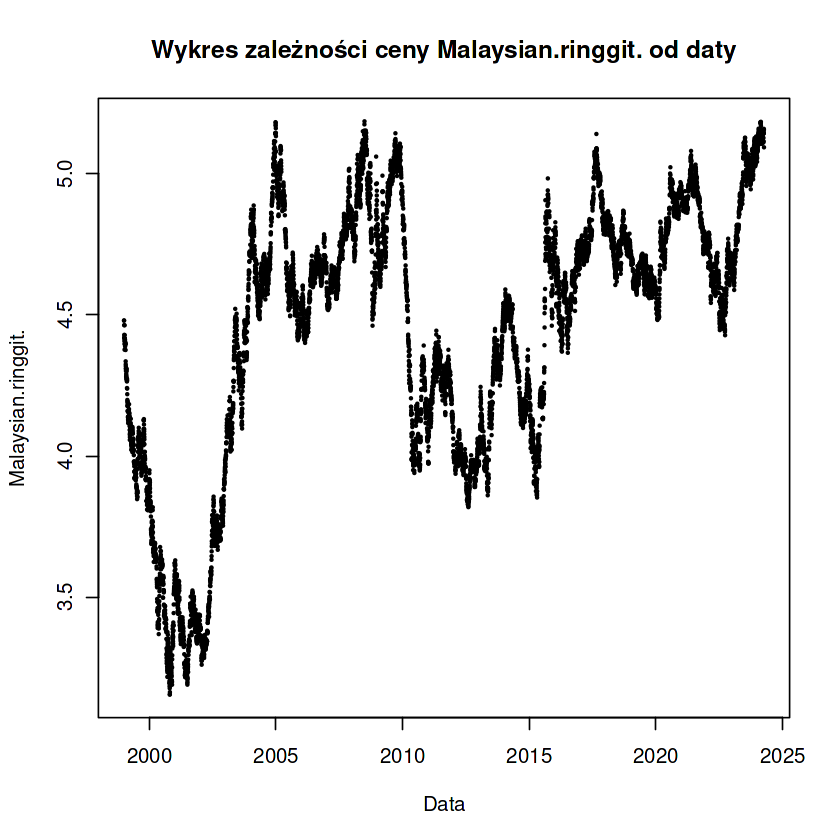

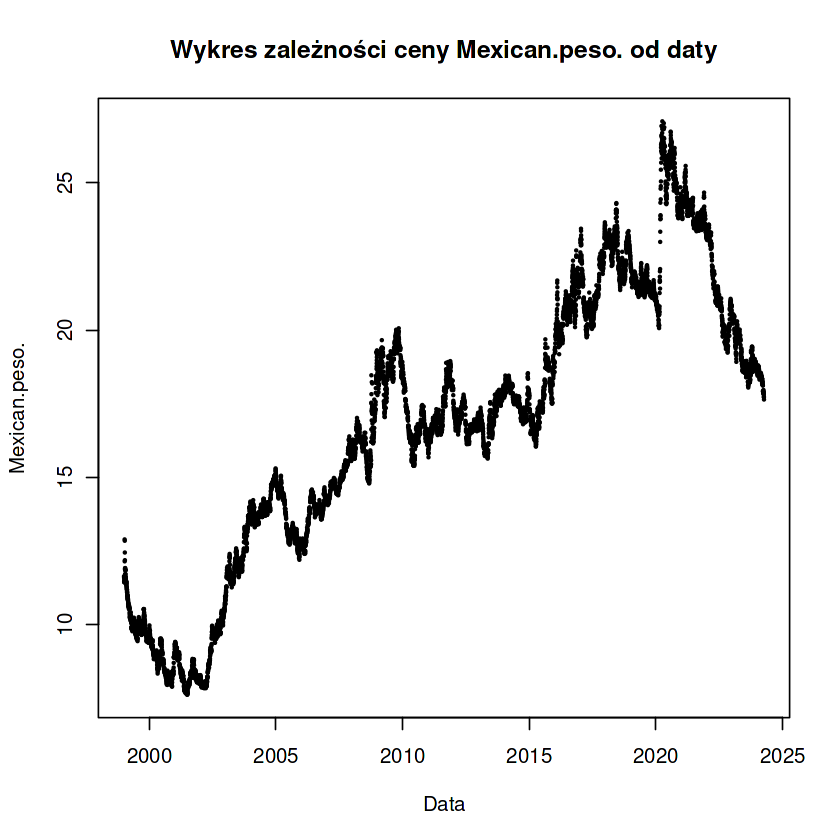

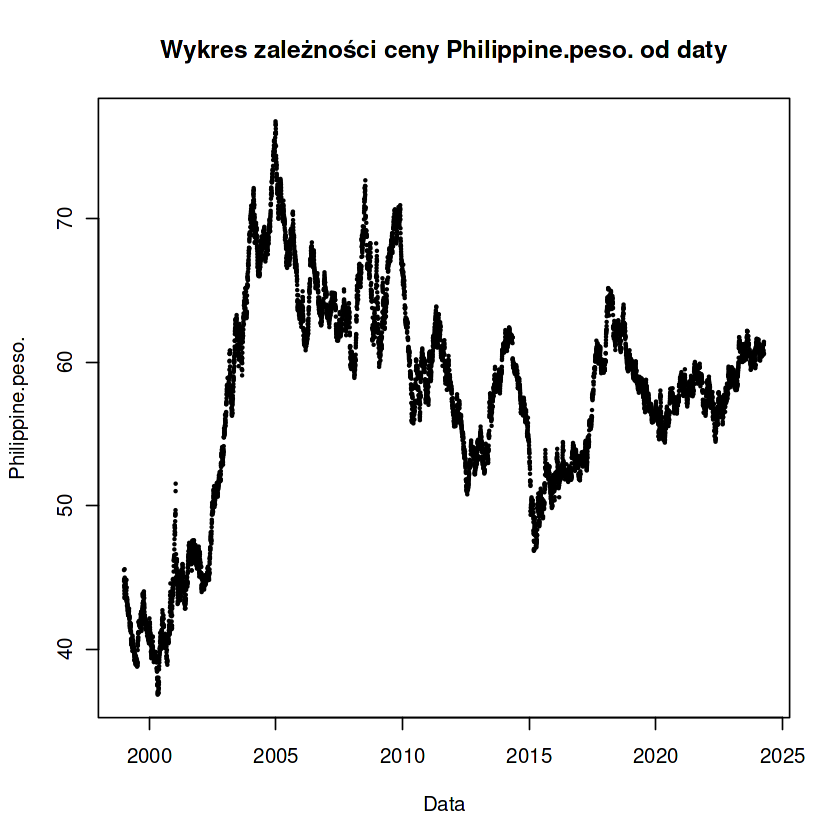

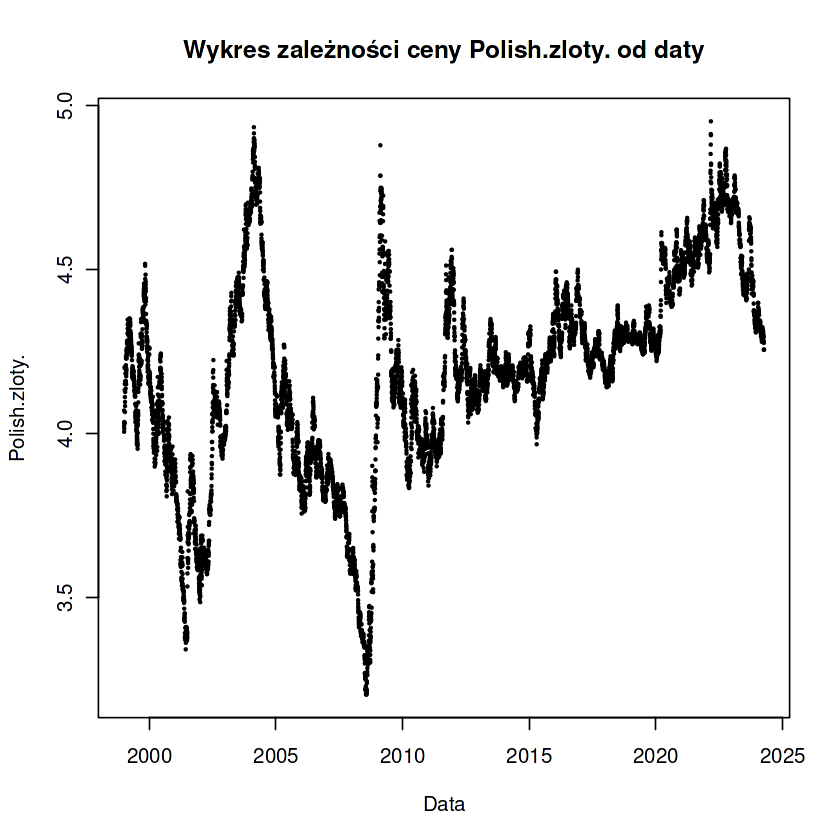

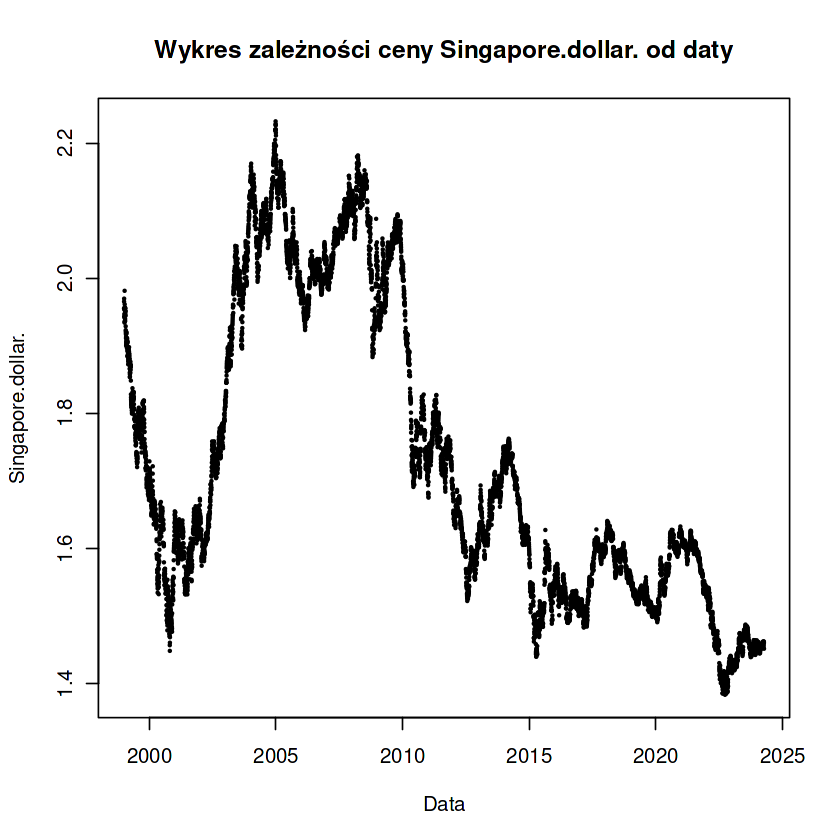

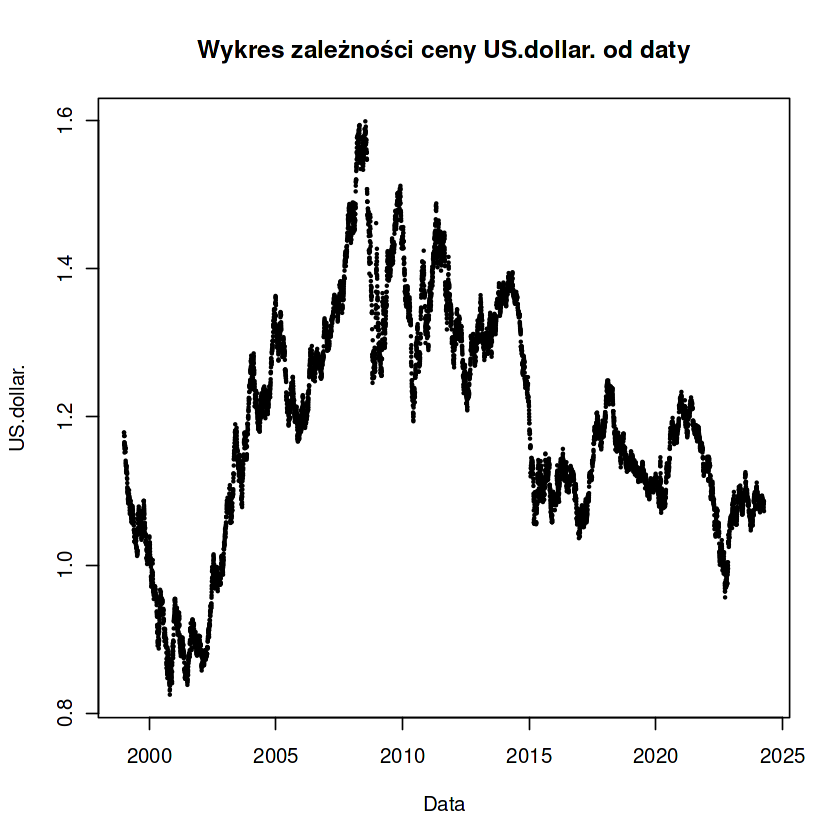

In [6]:
# Pobranie nazw kolumn oprócz pierwszej
currency_columns <- colnames(Dataset_clean)[-c(1)]

# Pętla przez wszystkie kolumny walut
for(currency in currency_columns) {
  plot_formula <- as.formula(paste(currency, "~ Data"))
  plot(plot_formula, data = Dataset_clean, pch = 20, cex = 0.3,
       main = paste("Wykres zależności ceny", currency, "od daty"))
}

Wykres przedstawiający kurs dolara australijskiego pokazuje interesujący trend. Na początku wartości tej waluty oscylowały w granicach 1.6-1.8, następnie kurs spadł, by po pewnym czasie ponownie wrócić do poziomu 1.6-1.8. Ta dynamika wskazuje na okresy spadków i wzrostów, co może być związane z różnymi czynnikami ekonomicznymi i rynkowymi.

Z kolei kurs korony czeskiej wykazuje wyraźny trend spadkowy. Początkowo jej wartość wynosiła około 35, ale później drastycznie spadła do poziomu 25. Taki spadek sugeruje istotne zmiany w gospodarce Czech, które mogły wpłynąć na osłabienie się tej waluty.

Kurs korony duńskiej prezentuje niezwykłą stabilność, oscylując w wąskim zakresie 7.43-7.46. Taka stabilność jest rzadko spotykana wśród walut i może świadczyć o silnej polityce monetarnej Danii oraz stabilnej sytuacji gospodarczej.

Dolar hongkoński wykazuje wzrostowy trend. Początkowo jego wartości były niskie, jednak z czasem zaczęły rosnąć. Taki wzrost może odzwierciedlać rosnące zaufanie inwestorów do tej waluty oraz pozytywne zmiany w gospodarce Hongkongu.

Kurs jena japońskiego jest zmienny, nie wykazując jednoznacznego trendu. Wartości tej waluty wahają się w przedziale od 100 do 160, co oznacza częste zmiany. Takie wahania mogą wynikać z różnorodnych czynników, w tym polityki monetarnej Japonii oraz globalnych nastrojów rynkowych.

W przypadku wona południowokoreańskiego możemy zaobserwować cykliczne zmiany. Na początku kurs oscylował w granicach 1200-1400, później wzrósł do poziomu 2000, a następnie powrócił do zakresu 1200-1400. Ta cykliczność może wskazywać na specyficzne zmiany gospodarcze i polityczne w Korei Południowej.

Ringgit malezyjski początkowo miał kurs około 3.5, ale obecnie oscyluje w granicach 4.5-5. Wzrost wartości tej waluty wskazuje na długoterminowy trend wzrostowy, który może być spowodowany poprawą sytuacji gospodarczej w Malezji.

Historia peso meksykańskiego pokazuje wyraźny trend wzrostowy. Kurs, który kiedyś był niski, oscylując w okolicach 10, na przestrzeni lat wzrósł do poziomu 25. Taki wzrost może świadczyć o rosnącej sile gospodarki Meksyku oraz zwiększonym zainteresowaniu inwestorów.

Wartość peso filipińskiego utrzymuje się na stabilnym poziomie 50-60, co wskazuje na stosunkowo małe wahania kursu tej waluty. Taka stabilność może być wynikiem skutecznej polityki monetarnej oraz stabilnych warunków gospodarczych na Filipinach.

Kurs polskiego złotego wykazuje umiarkowane wahania, oscylując w wartościach od 3.5 do 5. Obecnie wartość złotego utrzymuje się na poziomie ponad 4. Ta stabilność z lekkimi wahaniami może odzwierciedlać zmieniające się warunki gospodarcze w Polsce.

Dolar singapurski przeszedł wyraźny trend spadkowy. Początkowo jego kurs był dość wysoki, ale na przestrzeni lat znacząco zmalał. Taki spadek może sugerować osłabienie gospodarki Singapuru lub zmiany w globalnym popycie na tę walutę.

Dolar amerykański również wykazuje interesującą dynamikę. Na początku jego wartość oscylowała w granicach 0.8-1.2, później wzrosła nawet do 1.6, a obecnie utrzymuje się na poziomie 1-1.2. Taki wzrost, a następnie stabilizacja wskazują na zmiany w gospodarce USA oraz globalnych rynkach finansowych.

Podsumowując, każdy wykres przedstawia unikalną historię waluty, odzwierciedlającą zmiany gospodarcze, polityczne oraz globalne trendy rynkowe.


## Histogramy poszczególych walut

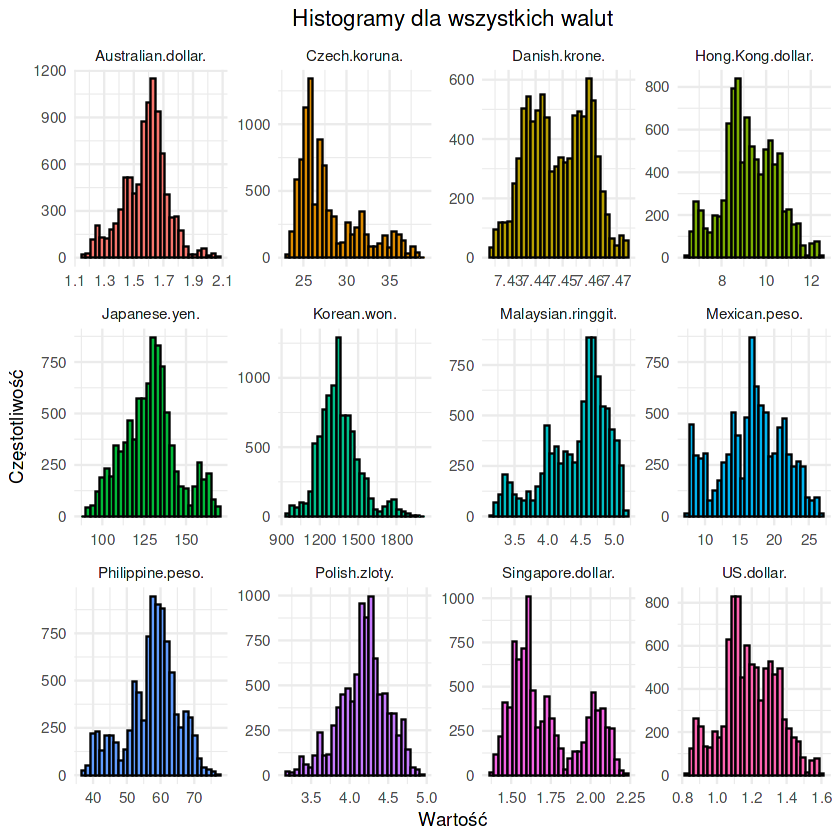

In [8]:
long_data <- Dataset_clean %>%
  pivot_longer(cols = where(is.numeric))

# Utworzenie histogramów dla każdej zmiennej numerycznej z różnymi kolorami
ggplot(long_data, aes(x = value, fill = name)) +
  geom_histogram(color = "black", bins = 30, show.legend = FALSE) +
  facet_wrap(~ name, scales = "free") +
  theme_minimal() +
  labs(
    title = "Histogramy dla wszystkich walut",
    x = "Wartość",
    y = "Częstotliwość"
  ) +
  theme(
    plot.title = element_text(hjust = 0.5)
  )

- Histogram dolara australijskiego pokazuje, że wartości są skoncentrowane w zakresie od 1.1 do 1.5, z najwyższą częstotliwością wokół 1.3, co wskazuje na lekką prawostronną asymetrię.

- Histogram korony czeskiej pokazuje, że najwięcej obserwacji jest skoncentrowanych wokół wartości 25, co sugeruje prawostronną asymetrię.

- Histogram korony duńskiej pokazuje rozproszone wartości z wyraźnymi szczytami w przedziałach 7.4-7.45 oraz 7.45-7.47, co również wskazuje na dwumodalny rozkład.

- Histogram dolara hongkońskiego wskazuje, że wartości są skoncentrowane w zakresie od 7.8 do 8.1, z najwyższą częstotliwością wokół 7.8, co sugeruje stabilny rozkład wartości.

- Histogram jena japońskiego pokazuje, że wartości są skoncentrowane w zakresie od 100 do 150, z najwyższą częstotliwością wokół 125, co wskazuje na prawostronną asymetrię.

- Histogram wona koreańskiego ukazuje zgrupowane wokół wartości 1300, co sugeruje prawostronną asymetrię.

- Histogram ringgita malezyjskiego wskazuje, że wartości są skoncentrowane wokół wartości 4.7, co sugeruje stosunkowo lewostronną asymertrię.

- Histogram peso meksykańskiego pokazuje, że wartości są zgrupowane wokół 7, 13, 17 i 22, co sugeruje wielomodalny rozkład.

- Histogram peso filipińskiego wskazuje, że wartości są skoncentrowane w zakresie od 40 do 60, z najwyższą częstotliwością wokół 50, co sugeruje stosunkowo symetryczny rozkład.

- Histogram polskiego złotego pokazuje, że najwięcej obserwacji jest skoncentrowanych wokół wartości 4,3, co sugeruje symetryczny rozkład.

- Histogram dolara singapurskiego wielomodalny, co oznacza, że posiada więcej niż jeden szczyt. Poza głównymi szczytami w zakresie 1.5-1.7, można zauważyć mniejsze szczyty w okolicach 2.0..

- Histogram dolara amerykańskiego przedstawia lewostronną asymetrię. Widać, że większa część danych jest skoncentrowana wokół niższych wartości, a mniejsze wartości są bardziej rozproszone.

# Modelowanie
W ramach tego projektu skupimy się na modelowaniu predykcyjnym kursów czterech kluczowych walut: dolar amerykański (US.dollar.), złoty polski (Polish.zloty.), jen japoński (Japanese.yen) oraz won koreański (Korean.won.). W naszym przypadku skorzystamy z zestawu danych zawierających historyczne notowania tych walut. Zbiór danych został podzielony w proporcjach: 50% obserwacji zostało przeznaczonych na zbiór treningowy, 25% na zbiór walidacyjny oraz 25% na zbiór testowy. Dodatkowo, przeprowadziliśmy normalizację danych, aby zapewnić spójność i optymalne warunki dla modeli predykcyjnych.

In [6]:
set.seed(2024)
num_train_samples <- round(nrow(Dataset_clean) * .5)
num_val_samples <- round(nrow(Dataset_clean) * 0.25)
num_test_samples <- nrow(Dataset_clean) - num_train_samples - num_val_samples

train_df <- Dataset_clean[seq(num_train_samples), ]

val_df <- Dataset_clean[seq(from = nrow(train_df) + 1,
                      length.out = num_val_samples), ]

test_df <- Dataset_clean[seq(to = nrow(Dataset_clean),
                       length.out = num_test_samples), ]

In [7]:
# Ustal kolumny wejściowe (z walutami)
input_data_colnames <- names(Dataset_clean) %>%
  setdiff(c("Data"))

# Normalizacja danych
normalization_values <- zip_lists(mean = lapply(train_df[input_data_colnames], mean),
                                  sd = lapply(train_df[input_data_colnames], sd))

In [8]:
normalize_input_data <- function(df) {
  normalize <- function(x, center, scale) {
    (x - center) / scale
  }

  for (col_nm in input_data_colnames) {
    col_nv <- normalization_values[[col_nm]]
    df[[col_nm]] <- normalize(df[[col_nm]], col_nv$mean, col_nv$sd)
  }
  return(df)
}

In [9]:
#Podzial danych danych do trenowania sieci neuronowycj

sampling_rate <- 1 # odstęp czasowy - jeden dzień
sequence_length <- 30 #obserwacje będą sięgać 30 dni wstecz 
delay <- 7 # liczba dni do przodu
batch_size <- 64 #liczba próbek danych używanych do obliczenia pojedynczego kroku

# Funkcja przygotowująca dane wejściowe i docelowe dla każdej waluty
df_to_inputs_and_targets <- function(df) {
  inputs <- df[input_data_colnames] %>%
    normalize_input_data() %>%
    as.matrix()

  targets_list <- lapply(input_data_colnames, function(col) {
    as.array(df[[col]])
  })

  list(
    head(inputs, -delay),
    lapply(targets_list, function(target) tail(target, -delay))
  )
}

# Funkcja do tworzenia datasetów dla każdej waluty
make_dataset <- function(df) {
  c(inputs, targets_list) %<-% df_to_inputs_and_targets(df)

  datasets <- lapply(seq_along(targets_list), function(i) {
    timeseries_dataset_from_array(
      inputs, targets_list[[i]],
      sampling_rate = sampling_rate,
      sequence_length = sequence_length,
      shuffle = TRUE,
      batch_size = batch_size
    )
  })

  names(datasets) <- input_data_colnames
  return(datasets)
}

# Tworzenie datasetów treningowych, walidacyjnych i testowych dla każdej waluty
train_datasets <- make_dataset(train_df)
val_datasets <- make_dataset(val_df)
test_datasets <- make_dataset(test_df)

## Model Bazowy
Jako model bazowy przyjmujemy, że cena za 7 dni utrzyma się na poziomie obecnej ceny. To prostsze podejście, które stanowi punkt wyjścia do porównań z bardziej zaawansowanymi metodami predykcyjnymi.

In [10]:
suppressPackageStartupMessages(library(tfdatasets))

# Funkcja oceniająca metodę bazową dla pojedynczej waluty
evaluate_naive_method <- function(dataset, currency) {
  unnormalize_currency <- function(x) {
    nv <- normalization_values[[currency]]
    (x * nv$sd) + nv$mean
  }

  currency_col_idx <- match(currency, input_data_colnames)

  reduction <- dataset %>%
    dataset_unbatch() %>%
    dataset_map(function(samples, target) {
      last_currency_in_input <- samples[-1, currency_col_idx]
      pred <- unnormalize_currency(last_currency_in_input)
      abs(pred - target)
    }) %>%
    dataset_reduce(
      initial_state = list(total_samples_seen = 0L,
                           total_abs_error = 0),
      reduce_func = function(state, element) {
        state$total_samples_seen %<>% `+`(1L)
        state$total_abs_error %<>% `+`(element)
        state
      }
    ) %>%
    lapply(as.numeric)

  mae <- with(reduction, total_abs_error / total_samples_seen)
  mae
}


In [13]:
# Wywołanie funkcji oceniającej metodę bazową dla każdej waluty
for (currency in input_data_colnames[-c(1,2,3,4,7,8,9,11)]) {
  mae <- evaluate_naive_method(test_datasets[[currency]], currency)
  cat("Test MAE dla waluty", currency, ":", mae, "\n")
}

Test MAE dla waluty Japanese.yen. : 1.885311 
Test MAE dla waluty Korean.won. : 16.74426 
Test MAE dla waluty Polish.zloty. : 0.04715597 
Test MAE dla waluty US.dollar. : 0.01415605 


## Model LSTM
Model LSTM jest to model składający się z warstw ułożonych sekwencyjnie. Na początku znajduje się warstwa LSTM z 64 jednostkami, dedykowana do modelowania danych sekwencyjnych. Aby zregularyzować wagi kernela, zastosowano regularyzację L2 z parametrem równym 0.001. Następnie dodano warstwę Dropout z współczynnikiem 0.2, której celem jest zapobieżenie przeuczeniu poprzez losowe wyłączanie części neuronów podczas treningu. Kolejne dwie warstwy są warstwami Dense z 32 jednostkami i funkcją aktywacji ReLU. Ponownie zastosowano regularyzację L2 dla wag kernela. Ostatnia warstwa Dense zawiera jedną jednostkę wyjściową. Model został skompilowany z optymalizatorem "rmsprop", funkcją straty "mse" (średni błąd kwadratowy) oraz metryką "mae" (średni błąd bezwzględny), co jest standardowym podejściem do problemów predykcji wartości liczbowych. Dla każdej z czterech wymienionych wcześniej walut zostanie stworzony oddzielny model.

In [11]:
# Ustalanie parametrów
input_shape <- c(sequence_length, length(input_data_colnames))

set.seed(2024)
# Definiowanie modelu
build_model <- function(input_shape) {
  model <- keras_model_sequential() %>%
    layer_lstm(units = 64, input_shape = input_shape,
               kernel_regularizer = regularizer_l2(0.001)) %>%
    layer_dropout(rate = 0.2) %>%
    layer_dense(units = 32, activation = 'relu', 
                kernel_regularizer = regularizer_l2(0.001)) %>%
    layer_dropout(rate = 0.2) %>%
    layer_dense(units = 32, activation = 'relu', 
                kernel_regularizer = regularizer_l2(0.001)) %>%
    layer_dropout(rate = 0.2) %>%
    layer_dense(units = 1)
  
  model %>% compile(
    optimizer = "rmsprop",
    loss = "mse",
    metrics = "mae"
  )
  
  return(model)
}

# Tworzenie modelu dla wybranych walut
model_usd <- build_model(input_shape)
model_pl <- build_model(input_shape)
model_jy <- build_model(input_shape)
model_kw <- build_model(input_shape)

In [10]:
# Funkcja trenowania modelu
train_model <- function(model, train_dataset, val_dataset) {
  model %>%
  fit(
    train_dataset,
    epochs = 30,
    validation_data = val_dataset
  )
}

In [11]:
evaluate_model<- function (model, test_dataset){
    results<- model%>%evaluate(test_dataset)
    return(results)
}

In [12]:
#Dane dla waluty US.dollar.
train_dataset_usd <- train_datasets[["US.dollar."]]
val_dataset_usd <- val_datasets[["US.dollar."]]
test_dataset_usd <- test_datasets[["US.dollar."]] 

In [19]:
#Trening modelu dla USD
history_lstm_usd<-train_model(model_usd, train_dataset_usd, val_dataset_usd)

In [20]:
evaluate_lstm_usd<-evaluate_model(model_usd, test_dataset_usd)

  cat("Test MAE dla US.dollar:", evaluate_lstm_usd[["mae"]])

Test MAE dla US.dollar: 0.1362619

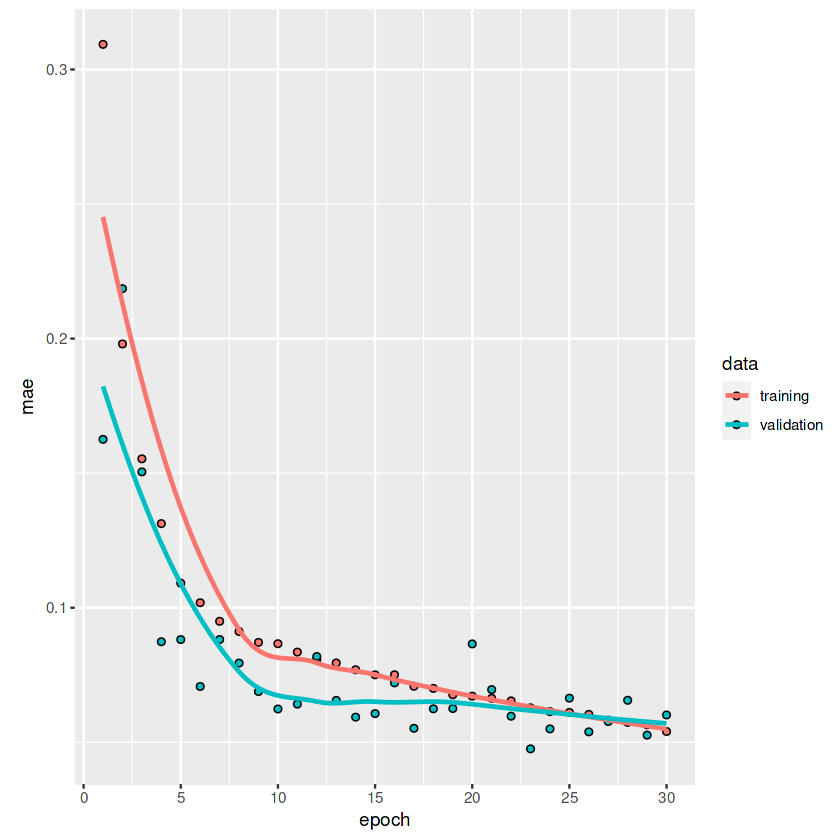

In [22]:
plot(history_lstm_usd, metrics = "mae")

Model LSTM do przewidywania kursu waluty USD pokazuje poprawne uczenie się na zbiorze treningowym i walidacyjnym, gdzie MAE systematycznie maleje w miarę zwiększania liczby epok. Jednakże, końcowy Test MAE dla modelu LSTM (0.1362619) jest znacząco wyższy niż dla modelu bazowego (0.01415606), co wskazuje na gorszą skuteczność modelu LSTM. 

In [13]:
# Pobieramy dataset dla Polish.zloty. z przygotowanych zbiorów
train_dataset_pl <- train_datasets[["Polish.zloty."]]
val_dataset_pl <- val_datasets[["Polish.zloty."]]
test_dataset_pl <- test_datasets[["Polish.zloty."]]

In [24]:
#Trening modelu dla Polish.zloty.
history_lstm_pl<-train_model(model_pl, train_dataset_pl, val_dataset_pl)

In [25]:
evaluate_lstm_pl<-evaluate_model(model_pl, test_dataset_pl)

cat("Test MAE dla Polish.zloty.:", evaluate_lstm_pl[["mae"]])

Test MAE dla Polish.zloty.: 0.1125543

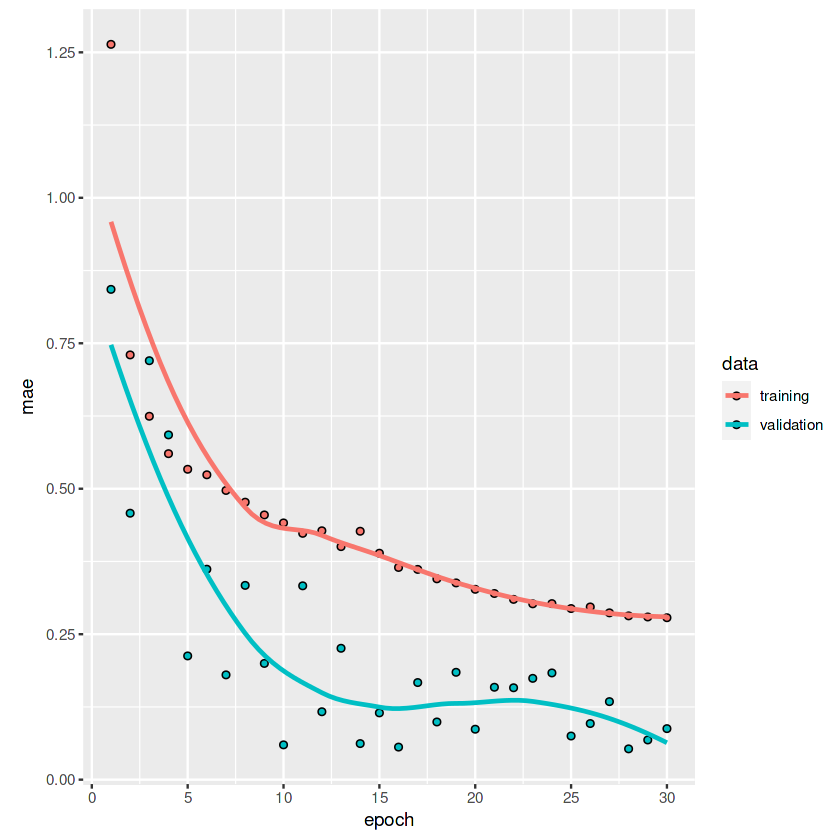

In [26]:
plot(history_lstm_pl, metrics = "mae")

Model LSTM dla przewidywania kursu polskiego złotego wykazuje prawidłowe uczenie się, gdzie MAE dla zbiorów treningowego i walidacyjnego systematycznie maleje wraz ze wzrostem liczby epok. Jednakże, końcowy Test MAE dla modelu LSTM wynosi 0.1125543, co jest wyższą wartością niż Test MAE dla modelu bazowego, który wynosi 0.04715593. To sugeruje, że model bazowy przewiduje kurs złotego bardziej precyzyjnie niż model LSTM. W związku z tym, model LSTM może wymagać dalszej optymalizacji.

In [14]:
# Pobieramy dataset dla Japanese.yen. z przygotowanych zbiorów
train_dataset_jy <- train_datasets[["Japanese.yen."]]
val_dataset_jy <- val_datasets[["Japanese.yen."]]
test_dataset_jy <- test_datasets[["Japanese.yen."]]

In [28]:
#Trening modelu dla Japanese.yen.
history_lstm_jy<-train_model(model_jy, train_dataset_jy, val_dataset_jy)

In [29]:
evaluate_lstm_jy<-evaluate_model(model_jy, test_dataset_jy)

cat("Test MAE dla Japanese.yen.:", evaluate_lstm_jy[["mae"]])

Test MAE dla Japanese.yen.: 16.45308

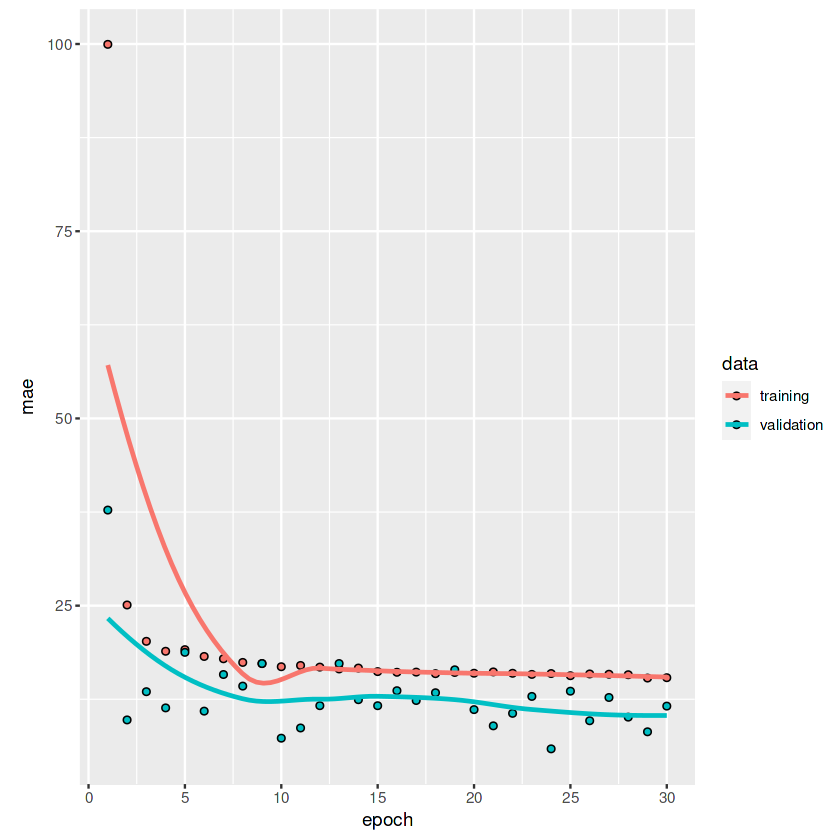

In [30]:
plot(history_lstm_jy, metrics = "mae")

Model LSTM dla przewidywania kursu jena japońskiego pokazuje, że MAE dla zbioru treningowego i walidacyjnego maleje wraz z liczbą epok, co wskazuje na poprawne uczenie się modelu. Jednakże, po osiągnięciu około 10 epok, MAE stabilizuje się, co oznacza, że model nie poprawia się dalej. Końcowy Test MAE dla modelu LSTM wynosi 16.45308, co jest znacznie gorszym wynikiem w porównaniu do modelu bazowego, którego Test MAE wynosi 1.885314. To sugeruje, że model bazowy jest znacznie bardziej precyzyjny w przewidywaniu kursu jena japońskiego niż model LSTM.

In [15]:
# Pobieramy dataset dla Korean.won. z przygotowanych zbiorów
train_dataset_kw <- train_datasets[["Korean.won."]]
val_dataset_kw <- val_datasets[["Korean.won."]]
test_dataset_kw <- test_datasets[["Korean.won."]]

In [32]:
#Trening modelu dla Korean.won.
set.seed(2024)
history_lstm_kw<-train_model(model_kw, train_dataset_kw, val_dataset_kw)

In [33]:
evaluate_lstm_kw<-evaluate_model(model_kw, test_dataset_kw)

cat("Test MAE dla Korean.won.:", evaluate_lstm_kw[["mae"]])

Test MAE dla Korean.won.: 247.9299

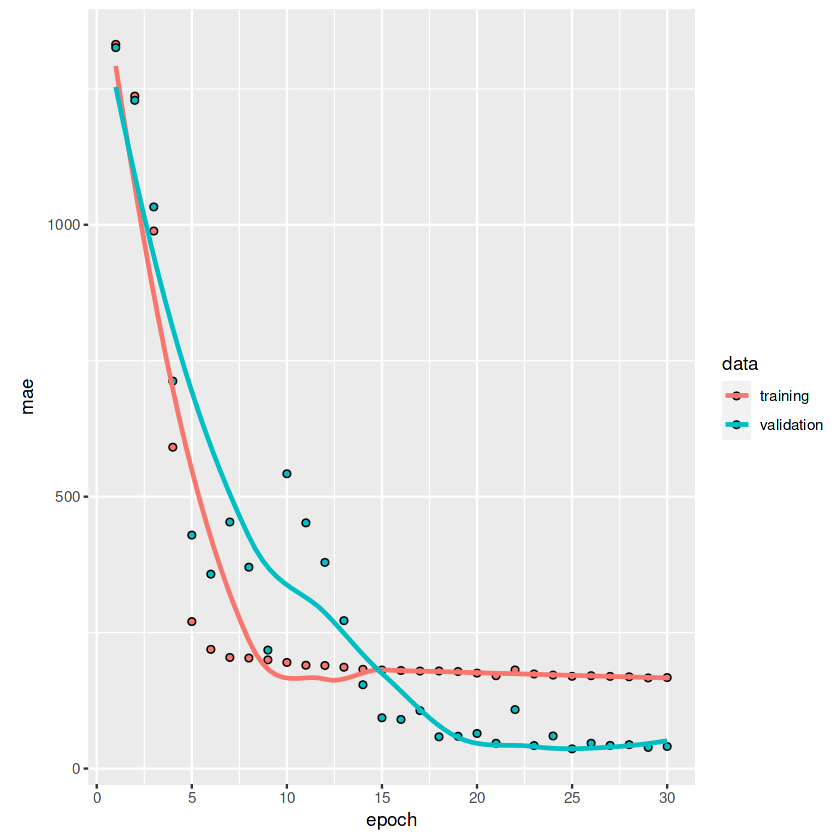

In [34]:
plot(history_lstm_kw, metrics = "mae")

Model do przewidywania kursu waluty wona koreańskiego pokazuje, że wartość MAE na początku dla obu zbiorów gwałtownie spada, co oznacza, że model szybko się uczy. Po około 10 epokach MAE dla zbioru treningowego stabilizuje się, podczas gdy dla walidacyjnego widać dalsze niewielkie spadki, ale też większą zmienność, co może wskazywać na niestabilność modelu lub jego trudność w generalizacji do nowych danych. Wynik końcowy MAE dla zbioru testowego wynosi 247.9299, co jest znacznie wyższe od bazowego MAE wynoszącego 16.74426.  

## Convolucja 1D
Model model_conv_1d, który zostanie zaprezętowany jest przykładem prostego modelu neuronowego konwolucyjnego 1D. Składa się on z dwóch warstw konwolucyjnych, które wykorzystują funkcję aktywacji ReLU i regularyzację L2 w celu redukcji przeuczenia. Po każdej z tych warstw następuje warstwa max pooling, która zmniejsza wymiarowość danych poprzez wybieranie maksymalnych wartości z określonych obszarów. Dodatkowo, warstwy dropout są stosowane w celu losowego wyłączania neuronów w celu poprawy ogólnej zdolności generalizacji modelu. Globalne uśrednianie danych jest następnie używane do redukcji wymiarowości przed przekazaniem ich do warstw gęstych, które generują ostateczne wyjście modelu. Model jest kompilowany z użyciem optymalizatora "rmsprop", funkcji straty "mse" (średni błąd kwadratowy) oraz metryki "mae" (średni błąd bezwzględny), co czyni go odpowiednim do zadań regresyjnych, gdzie dokładność predykcji jest kluczowa.

In [24]:
set.seed(2024)
# Ustalanie parametrów
input_shape <- c(sequence_length, length(input_data_colnames))

# Definiowanie modelu z regularizacją i dropout
model_conv_1d <- function(input_shape) {
  model_1d <- keras_model_sequential() %>%
    layer_conv_1d(filters = 8, kernel_size = 3, activation = "relu", 
                  input_shape = input_shape, kernel_regularizer = regularizer_l2(0.001)) %>%
    layer_max_pooling_1d(pool_size = 2) %>%
    layer_dropout(rate = 0.2) %>%
    layer_conv_1d(filters = 8, kernel_size = 2, activation = "relu",
                  kernel_regularizer = regularizer_l2(0.001)) %>%
    layer_global_average_pooling_1d() %>%
    layer_dropout(rate = 0.2) %>%
    layer_dense(units = 1)

  model_1d %>% compile(
    optimizer = "rmsprop",
    loss = "mse",
    metrics = "mae"
  )
  
  return(model_1d)
}

# Tworzenie modeli dla wybranych walut
model_1d_usd <- model_conv_1d(input_shape)
model_1d_pl <- model_conv_1d(input_shape)
model_1d_jy <- model_conv_1d(input_shape)
model_1d_kw <- model_conv_1d(input_shape)

In [36]:
# Trenowanie dla US.dollar
history_1d_usd<-train_model(model_1d_usd, train_dataset_usd, val_dataset_usd)

In [37]:
evaluate_1d_usd<-evaluate_model(model_1d_usd, test_dataset_usd)

  cat("Test MAE dla US.dollar:", evaluate_1d_usd[["mae"]])

Test MAE dla US.dollar: 0.06484854

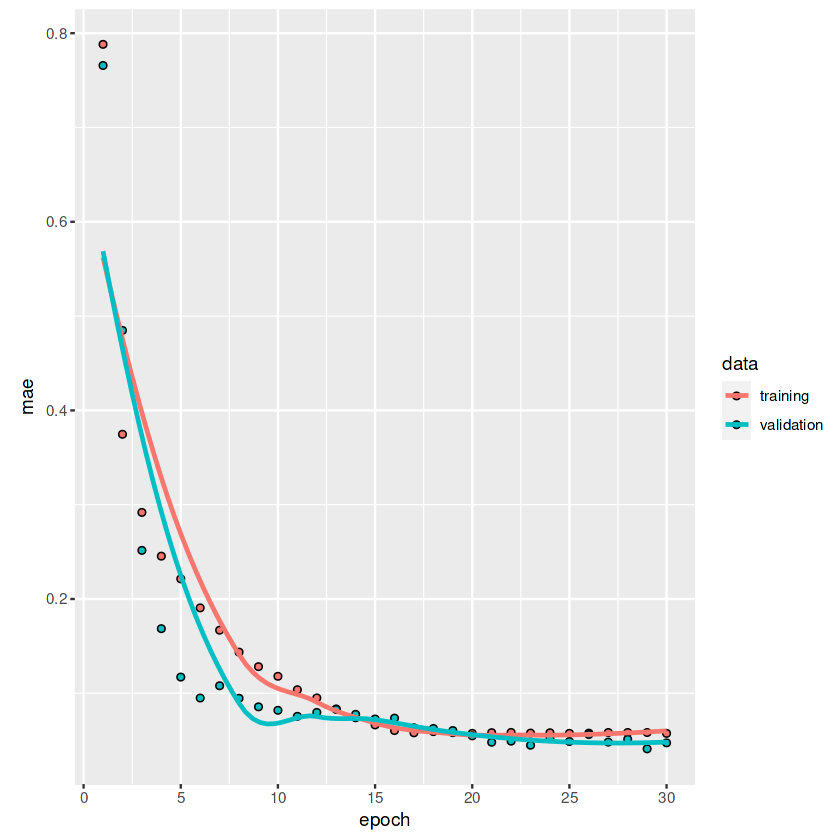

In [38]:
plot(history_1d_usd, metrics = "mae")

Model konwolucyjny 1D do przewidywania kursu dolara amerykańskiego wykazuje poprawne uczenie się, gdzie MAE dla zbioru treningowego i walidacyjnego systematycznie maleje przez pierwsze 10 epok. Po tym czasie MAE stabilizuje się dla obu zbiorów, wskazując na osiągnięcie optymalnej wydajności modelu. Końcowy Test MAE dla modelu wynosi 0.06484854, co jest nienajgorszym wynikiem, jednak wartość ta jest większa niż MAE modelu bazowego (0.01415606). Oznacza to, że model konwolucyjny 1D ma gorszą skuteczność w porównaniu do modelu bazowego.

In [39]:
#Trenowanie dla Polish.zloty.
history_1d_pl<-train_model(model_1d_pl, train_dataset_pl, val_dataset_pl)

In [40]:
evaluate_1d_pl<-evaluate_model(model_1d_pl, test_dataset_pl)

cat("Test MAE dla Polish.zloty.:", evaluate_1d_pl[["mae"]])

Test MAE dla Polish.zloty.: 0.3195384

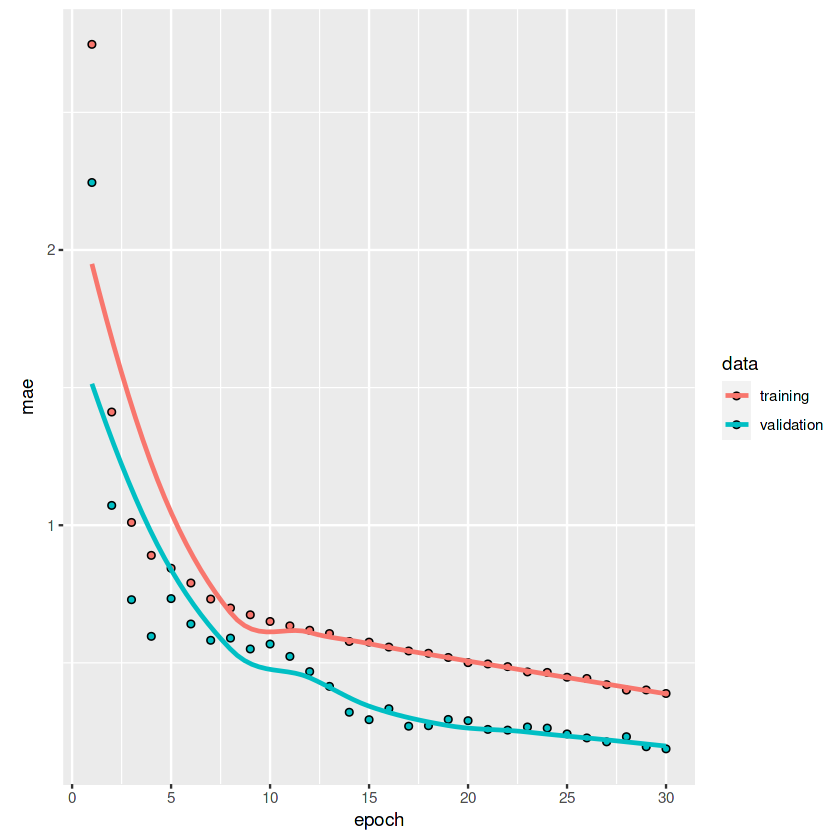

In [41]:
plot(history_1d_pl, metrics = "mae")

Model konwolucyjny 1D do przewidywania kursu polskiego złotego pokazuje systematyczne zmniejszanie się MAE dla zbioru treningowego i walidacyjnego w pierwszych 10 epokach. Po tym okresie MAE dla obu zbiorów stabilizuje się, wskazując na zakończenie procesu uczenia. Końcowy Test MAE dla modelu wynosi 0.3195384, co jest wyższe niż MAE modelu bazowego wynoszące 0.04715593. Oznacza to, że mimo poprawnego procesu uczenia, model konwolucyjny 1D ma gorszą skuteczność w porównaniu do prostszej metody bazowej.

In [42]:
# Trenoiwanie dla Japanese.yen.
history_1d_jy<-train_model(model_1d_jy, train_dataset_jy, val_dataset_jy)

In [43]:
evaluate_1d_jy<-evaluate_model(model_1d_jy, test_dataset_jy)

cat("Test MAE dla Japanese.yen.:", evaluate_1d_jy[["mae"]])

Test MAE dla Japanese.yen.: 16.34931

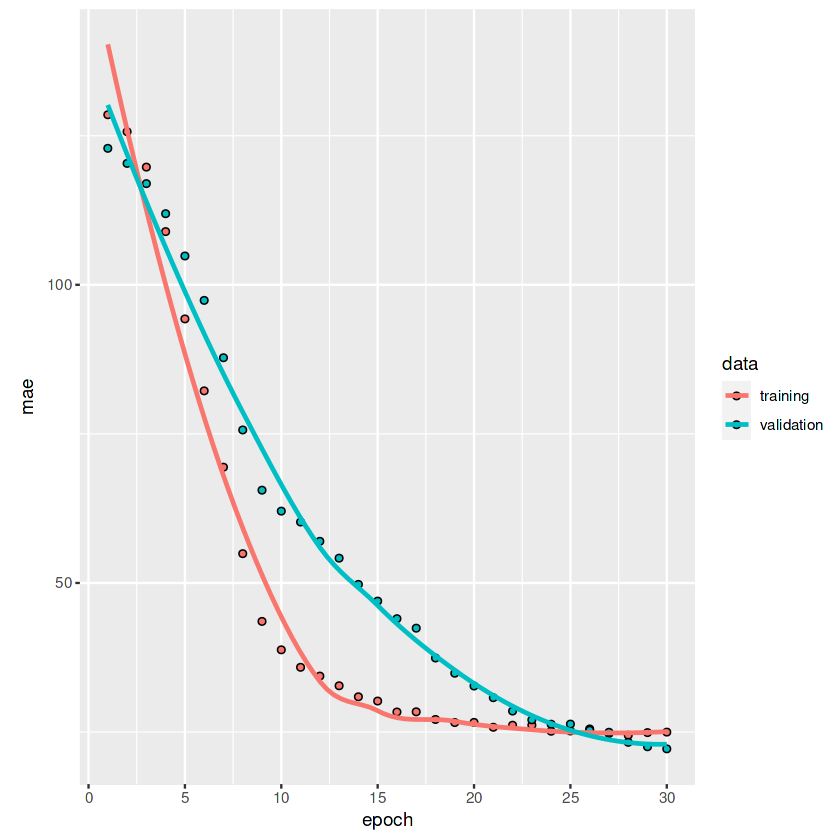

In [44]:
plot(history_1d_jy, metrics = "mae")

Wykres przedstawia zmniejszanie się średniego błędu absolutnego (MAE) dla zbiorów treningowych i walidacyjnych w miarę postępu epok w modelu konwolucji 1D dla prognozowania kursu japońskiego jena. Model dobrze się uczy, a jego MAE na zbiorze walidacyjnym stabilizuje się po około 20 epokach, co wskazuje na dobrą generalizację. MAE na zbiorze testowym wynosi 16.34931, co jest jednak znacznie wyższą wartością niż MAE modelu bazowego, który wynosi 1.885314. Oznacza to, że model konwolucji 1D jest mniej dokładny niż model bazowy w prognozowaniu wartości jena.

In [45]:
#Trening dla Korean.won.
set.seed(2024)
history_1d_kw<-train_model(model_1d_kw, train_dataset_kw, val_dataset_kw)

In [46]:
evaluate_1d_kw<-evaluate_model(model_1d_kw, test_dataset_kw)

cat("Test MAE dla Korean.won.:", evaluate_1d_kw[["mae"]])

Test MAE dla Korean.won.: 116.306

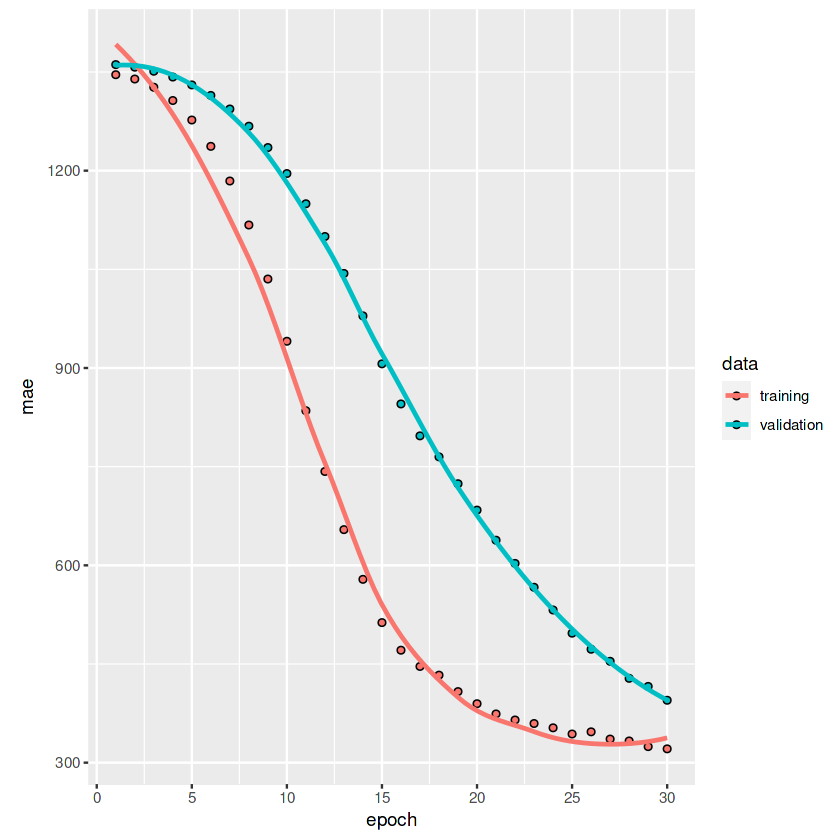

In [47]:
plot(history_1d_kw, metrics = "mae")

Wykres przedstawia zmniejszanie się średniego błędu absolutnego (MAE) dla zbiorów treningowych i walidacyjnych w miarę postępu epok w modelu konwolucji 1D prognozującym kurs koreańskiego wona. MAE na zbiorze walidacyjnym spada stopniowo, co wskazuje na efektywne uczenie się modelu. Jednak historia uczenia pokazuje, że MAE dla zbioru walidacyjnego jest stale wyższe niż dla zbioru treningowego, co może świadczyć o przeuczeniu modelu. MAE na zbiorze testowym wynosi 116.306, co jest znacznie wyższą wartością niż MAE modelu bazowego, który wynosi 16.74426. Oznacza to, że model konwolucji 1D jest znacznie mniej dokładny w prognozowaniu kursu koreańskiego wona niż model bazowy. Pomimo dobrej zbieżności na zbiorach treningowych i walidacyjnych, model konwolucji nie przewyższa modelu bazowego na danych testowych.

## Sieć gęsta
Model sieci gęstej składa się z kilku warstw zaprojektowanych do przetwarzania danych wejściowych i dokonywania przewidywań. Pierwsza warstwa to warstwa gęsta z 64 jednostkami, używająca funkcji aktywacji ReLU i regularizacji L2, aby zapobiec przeuczeniu. Następnie zastosowano warstwę MaxPooling1D, która zmniejsza rozmiar danych, co pomaga w redukcji liczby parametrów i zapobiega przeuczeniu. Po niej znajduje się warstwa flatten, która przekształca dane do jednowymiarowego wektora. Kolejna warstwa to ponownie warstwa gęsta, tym razem z 32 jednostkami i funkcją aktywacji ReLU oraz regularizacją L2. Na końcu znajduje się warstwa gęsta z jednym neuronem, odpowiedzialnym za końcowe przewidywanie wartości, a cały model jest kompilowany z użyciem optymalizatora RMSprop, funkcji straty MSE oraz metryki MAE.

In [17]:
set.seed(2024)

sequence_length <- 30  
input_data_colnames <- 12  

input_shape <- c(sequence_length, input_data_colnames)

# Definiowanie modelu
model_siec <- function(input_shape) {
  model_sg <- keras_model_sequential() %>%
    layer_dense(units = 64, activation = "relu", input_shape = input_shape, kernel_regularizer = regularizer_l2(0.001)) %>%
    layer_max_pooling_1d(pool_size = 2) %>%
    layer_flatten() %>%
    layer_dense(units = 32, activation = "relu", kernel_regularizer = regularizer_l2(0.001)) %>%
    layer_dense(units = 1)
  
  model_sg %>% compile(
    optimizer = "rmsprop",
    loss = "mse",
    metrics = "mae"
  )
  
  return(model_sg)
}

# Tworzenie modelu dla wybranych walut
model_sg_usd <- model_siec(input_shape)
model_sg_pl <- model_siec(input_shape)
model_sg_jy <- model_siec(input_shape)
model_sg_kw <- model_siec(input_shape)

In [30]:
# Historia treningu dla US.dollar
set.seed(2024)
history_sg_usd<-train_model(model_sg_usd, train_dataset_usd, val_dataset_usd)

In [31]:
evaluate_sg_usd<-evaluate_model(model_sg_usd, test_dataset_usd)

  cat("Test MAE dla US.dollar.:", evaluate_sg_usd[["mae"]])

Test MAE dla US.dollar.: 0.6704531

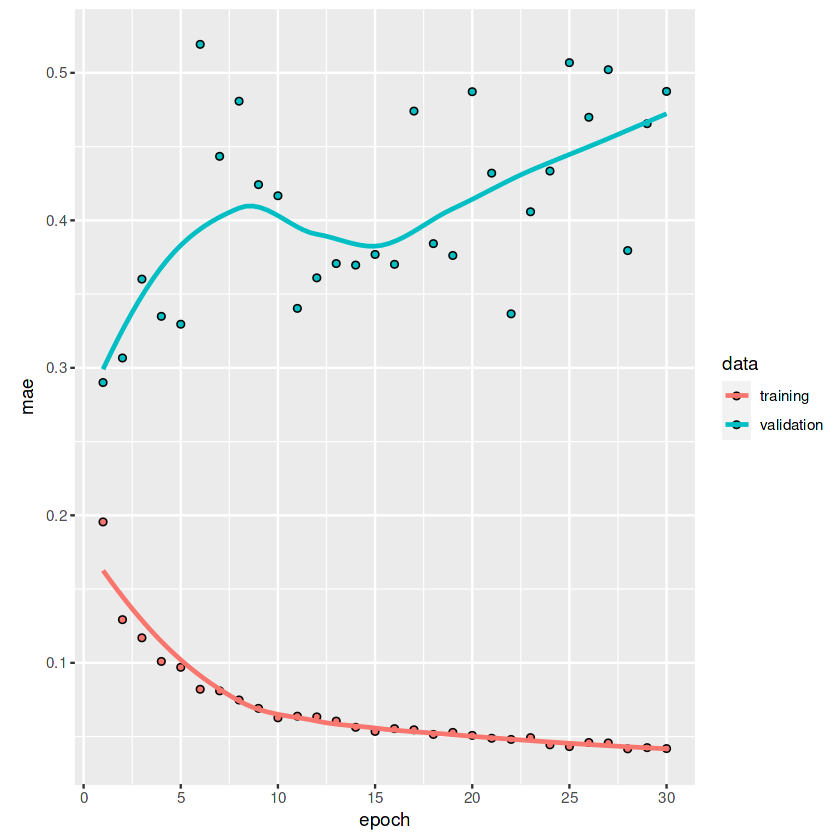

In [20]:
plot(history_sg_usd, metrics = "mae")

Wyniki przedstawione na wykresie wskazują, że model sieci gęstej dla dolara amerykańskiego ma problemy z ogólnością, ponieważ MAE dla danych walidacyjnych jest znacznie wyższe niż dla danych treningowych. Test MAE dla modelu sieci gęstej wynosi 0.6704531, co jest znacznie gorszym wynikiem w porównaniu do modelu bazowego, który osiąga Test MAE wynoszący 0.01415606. Taka duża różnica sugeruje, że model sieci gęstej jest przeuczony, dobrze dopasowując się do danych treningowych, ale nie radząc sobie z nowymi danymi.

In [21]:
#Trenowanie dla Polish.zloty.
history_sg_pl<-train_model(model_sg_pl, train_dataset_pl, val_dataset_pl)

In [22]:
evaluate_sg_pl<-evaluate_model(model_sg_pl, test_dataset_pl)

cat("Test MAE dla Polish.zloty.:", evaluate_sg_pl[["mae"]])

Test MAE dla Polish.zloty.: 0.9917331

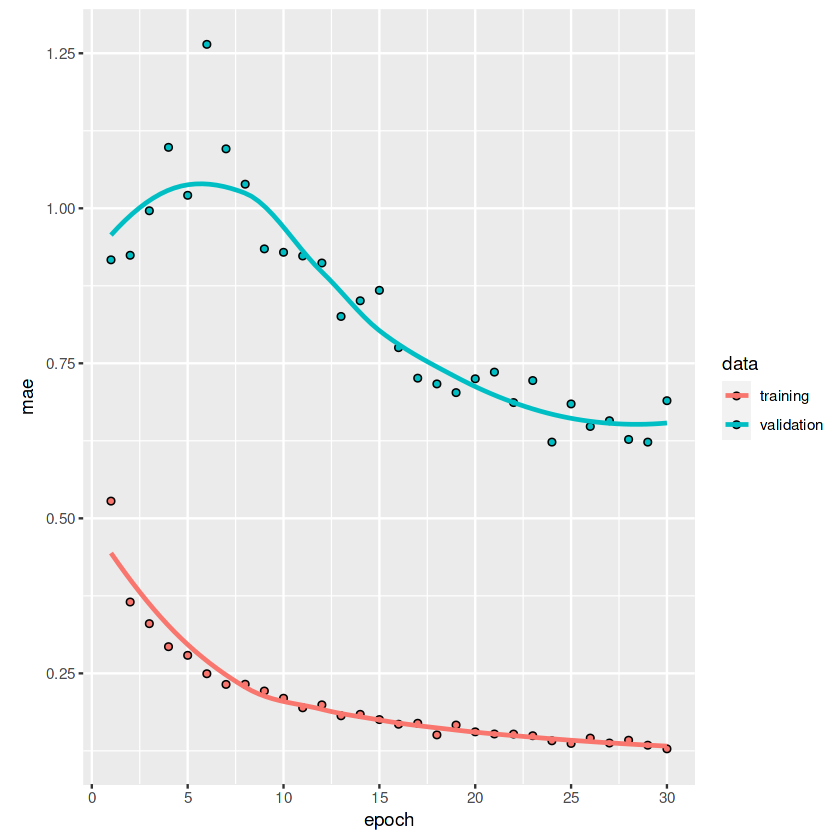

In [23]:
plot(history_sg_pl, metrics = "mae")

Wyniki pokazują, że model sieci gęstej ma znacznie wyższe MAE dla danych walidacyjnych niż dla danych treningowych, co sugeruje problemy z ogólnością modelu. Test MAE dla polskiej złotówki wynosi 0.9917331, co jest znacznie gorszym wynikiem w porównaniu do modelu bazowego, który osiąga Test MAE wynoszący 0.04715593. Wykres pokazuje, że MAE dla danych walidacyjnych maleje, ale pozostaje na wysokim poziomie, podczas gdy MAE dla danych treningowych systematycznie maleje, co może wskazywać na przeuczenie modelu. Model sieci gęstej dobrze dopasowuje się do danych treningowych, ale nie radzi sobie z nowymi danymi.

In [24]:
# Trenoiwanie dla Japanese.yen.
history_sg_jy<-train_model(model_sg_jy, train_dataset_jy, val_dataset_jy)

In [25]:
evaluate_sg_jy<-evaluate_model(model_sg_jy, test_dataset_jy)

cat("Test MAE dla Japanese.yen.:", evaluate_sg_jy[["mae"]])

Test MAE dla Japanese.yen.: 46.44864

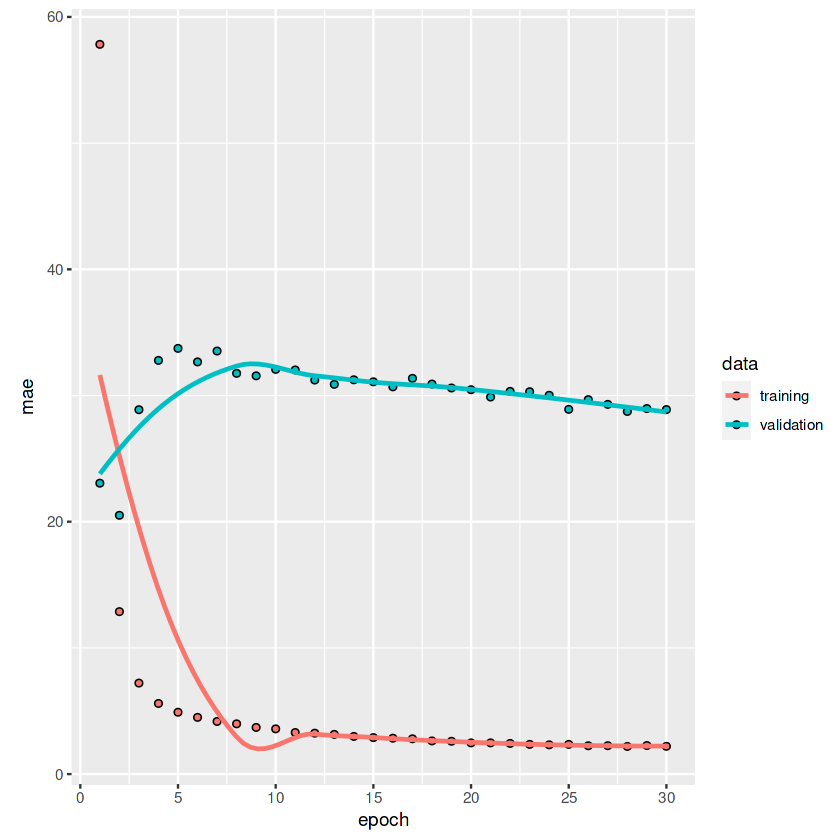

In [26]:
plot(history_sg_jy, metrics = "mae")

Na wykresie przedstawiono wartości MAE dla modelu sieci gęstej prognozującego kurs japońskiego jena w zależności od liczby epok. Czerwona linia pokazuje błąd dla zbioru treningowego, który szybko maleje, osiągając niski poziom, co sugeruje, że model dobrze uczy się na danych treningowych. Niebieska linia przedstawia błąd dla zbioru walidacyjnego, który po początkowym spadku stabilizuje się na wyższym poziomie niż dla zbioru treningowego, co może wskazywać na problem z przeuczeniem modelu.
MAE dla zbioru testowego wynosi 56.75646, co jest znacznie wyższą wartością w porównaniu z modelem bazowym, który osiągnął MAE równy 1.885314. Sugeruje to, że mimo niskiego błędu na zbiorze treningowym, model nie generalizuje dobrze na nowych danych i w praktyce wypada znacznie gorzej od prostszego modelu bazowego.

In [27]:
#Trening dla Korean.won.
history_sg_kw<-train_model(model_sg_kw, train_dataset_kw, val_dataset_kw)

In [28]:
evaluate_sg_kw<-evaluate_model(model_sg_kw, test_dataset_kw)

cat("Test MAE dla Korean.won.:", evaluate_sg_kw[["mae"]])

Test MAE dla Korean.won.: 397.961

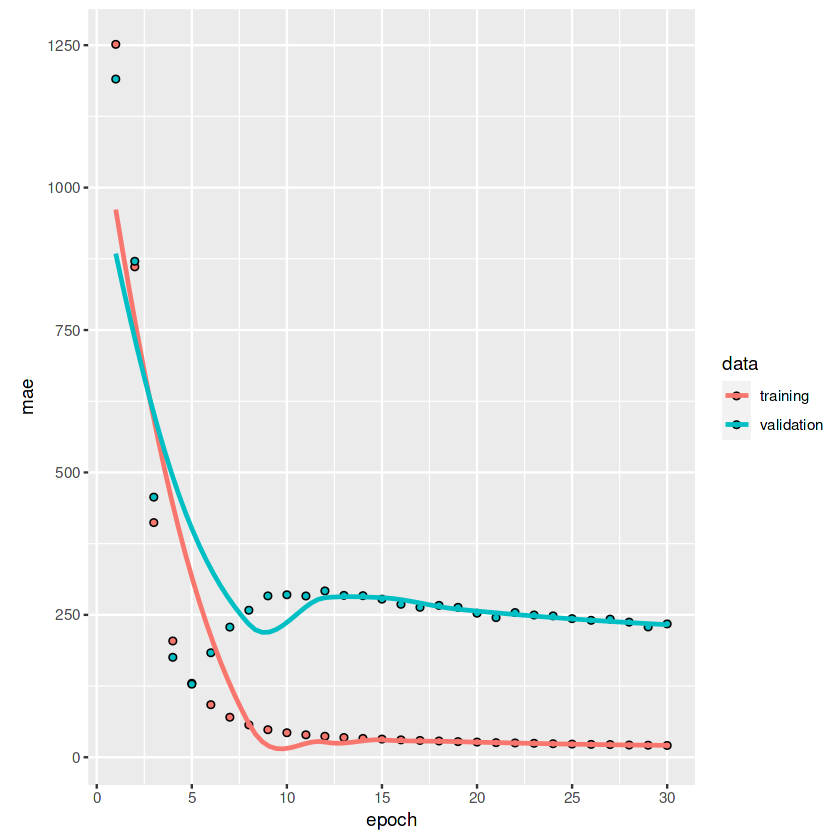

In [29]:
plot(history_sg_kw, metrics = "mae")

Model sieći gestej dla przewidywania kursu wona koreańskieho pokazuje, że MAE dla zbioru treningowego i walidacyjnego maleje wraz z liczbą epok, co wskazuje na poprawne uczenie się modelu. Jednakże, po osiągnięciu około 10 epok, MAE stabilizuje się, co oznacza, że model nie poprawia się dalej. Jednakże historia uczenia pokazuje, że MAE dla zbioru walidacyjnego jest stale wyższe niż dla zbioru treningowego, co może świadczyć o przeuczeniu modelu. Wartość MAE dla modelu sieci gęstej wynosi 16.45308, co jest znacznie gorszym wynikiem w porównaniu do modelu bazowego, którego MAE na zbiorze testowym wynosi 1.885314. To sugeruje, że model bazowy jest znacznie bardziej precyzyjny w przewidywaniu kursu wona koreańskiego niż model sieci gęstej.

## Model GRU
Model GRU (Gated Recurrent Units) jest prostym modelem sieci neuronowej typu feedforward. Rozpoczyna się od warstwy layer_flatten, która spłaszcza dane wejściowe aby mogły być przekazane do warstw gęstych. Pierwsza warstwa gęsta zawiera 64 neurony z funkcją aktywacji ReLU oraz regularyzacją L2, co pomaga w redukcji przeuczenia poprzez karanie dużych wartości wag. Następnie dane są przekazywane do warstwy layer_max_pooling_1d, która zmniejsza wymiarowość danych przez wybieranie maksymalnych wartości z określonych obszarów. Kolejna warstwa gęsta zawiera 32 neurony również z funkcją aktywacji ReLU i regularyzacją L2. Ostatnia warstwa gęsta ma jedynie jeden neuron wyjściowy, co jest typowe dla problemów regresyjnych, gdzie model przewiduje pojedynczą wartość wyjściową. Model jest kompilowany z użyciem optymalizatora "rmsprop", funkcji straty "mse" (średni błąd kwadratowy) oraz metryki "mae" (średni błąd bezwzględny), co pozwala na ocenę jego skuteczności w zadaniach regresyjnych.

In [25]:
set.seed(2024)

# Definiowanie modelu GRU z regularizacją i dropout
model_gru <- function(input_shape) {
  model_gru <- keras_model_sequential() %>%
    layer_gru(32, 
              recurrent_dropout = 0.5, 
              return_sequences = TRUE, 
              input_shape = input_shape, 
              kernel_regularizer = regularizer_l2(0.01), 
              recurrent_regularizer = regularizer_l2(0.01)) %>%
    layer_gru(32, 
              recurrent_dropout = 0.5, 
              kernel_regularizer = regularizer_l2(0.01), 
              recurrent_regularizer = regularizer_l2(0.01)) %>%
    layer_dropout(0.5) %>%
    layer_dense(1, kernel_regularizer = regularizer_l2(0.01))

  model_gru %>% compile(
    optimizer = "rmsprop",
    loss = "mse",
    metrics = "mae"
  )
  
  return(model_gru)
}

# Tworzenie modeli dla wybranych walut
model_gru_usd <- model_gru(input_shape)
model_gru_pl <- model_gru(input_shape)
model_gru_jy <- model_gru(input_shape)
model_gru_kw <- model_gru(input_shape)

In [115]:
# Trenowanie dla US.dollar
history_gru_usd<-train_model(model_gru_usd, train_dataset_usd, val_dataset_usd)

In [116]:
evaluate_gru_usd<-evaluate_model(model_gru_usd, test_dataset_usd)

  cat("Test MAE dla US.dollar:", evaluate_gru_usd[["mae"]])

Test MAE dla US.dollar: 0.1285173

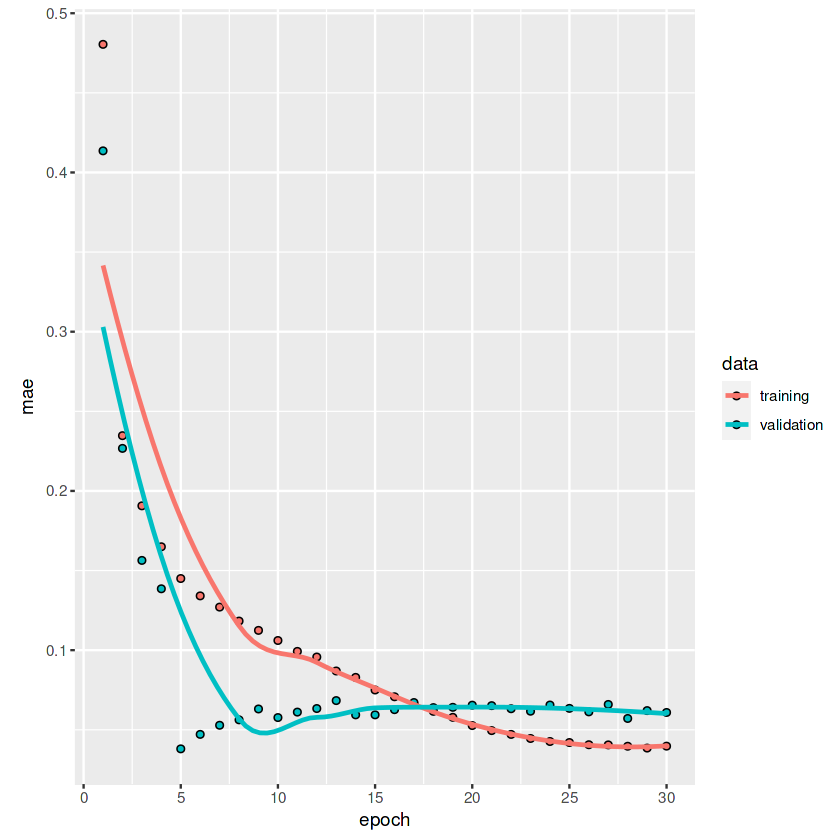

In [117]:
plot(history_gru_usd, metrics = "mae")

Wykres przedstawia przebieg błędu średniokwadratowego (MAE) dla zbiorów treningowego i walidacyjnego w trakcie 30 epok trenowania modelu GRU do przewidywania kursu dolara amerykańskiego. Początkowo MAE gwałtownie maleje dla obu zbiorów, co wskazuje na szybkie uczenie się modelu. Jednak po około 8 epokach, MAE dla zbioru walidacyjnego zaczyna rosnąć, co może sugerować nadmierne dopasowanie modelu do danych treningowych (overfitting). Ostateczne MAE na zbiorze testowym dla tego modelu wynosi 0.1285173, co jest wyższą wartością niż dla modelu bazowego (0.01415606). Może to oznaczać, że model GRU nie jest wystarczająco dobrze dostrojony, lub że model bazowy jest znacznie prostszy, ale bardziej efektywny.

In [118]:
#Trenowanie dla Polish.zloty.
history_gru_pl<-train_model(model_gru_pl, train_dataset_pl, val_dataset_pl)

In [67]:
evaluate_gru_pl<-evaluate_model(model_gru_pl, test_dataset_pl)

cat("Test MAE dla Polish.zloty.:", evaluate_gru_pl[["mae"]])

Test MAE dla Polish.zloty.: 0.369449

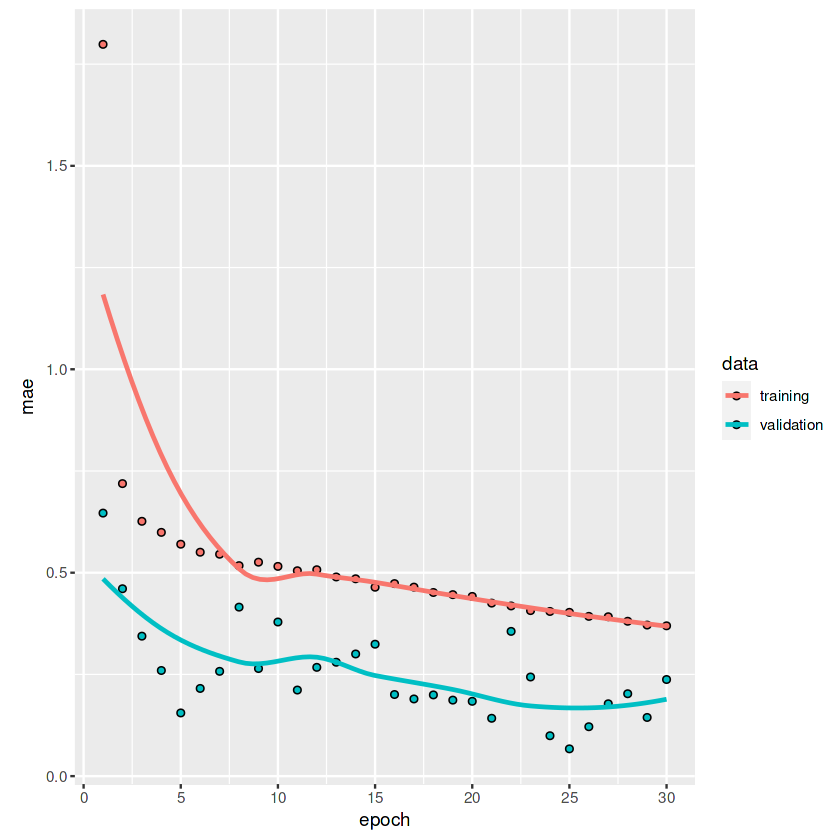

In [68]:
plot(history_gru_pl, metrics = "mae")

Wykres przedstawia błędy średniokwadratowe (MAE) dla zbiorów treningowego i walidacyjnego w trakcie 30 epok trenowania modelu GRU do przewidywania kursu polskiego złotego. Widać, że MAE dla zbioru treningowego i walidacyjnego maleje systematycznie, co wskazuje na poprawę dopasowania modelu do danych treningowych. Ostateczne MAE na zbiorze testowym wynosi 0.369449, co jest znacznie słabszym wynikiem niż w modelu bazowym (0.04715593), sugerując, że model GRU może nie być wystarczająco dobrze dostrojony do tego zadania, lub że model bazowy radzi sobie lepiej w przewidywaniu kursu złotego.

In [69]:
# Trenoiwanie dla Japanese.yen.
history_gru_jy<-train_model(model_gru_jy, train_dataset_jy, val_dataset_jy)

In [70]:
evaluate_gru_jy<-evaluate_model(model_gru_jy, test_dataset_jy)

cat("Test MAE dla Japanese.yen.:", evaluate_gru_jy[["mae"]])

Test MAE dla Japanese.yen.: 56.45429

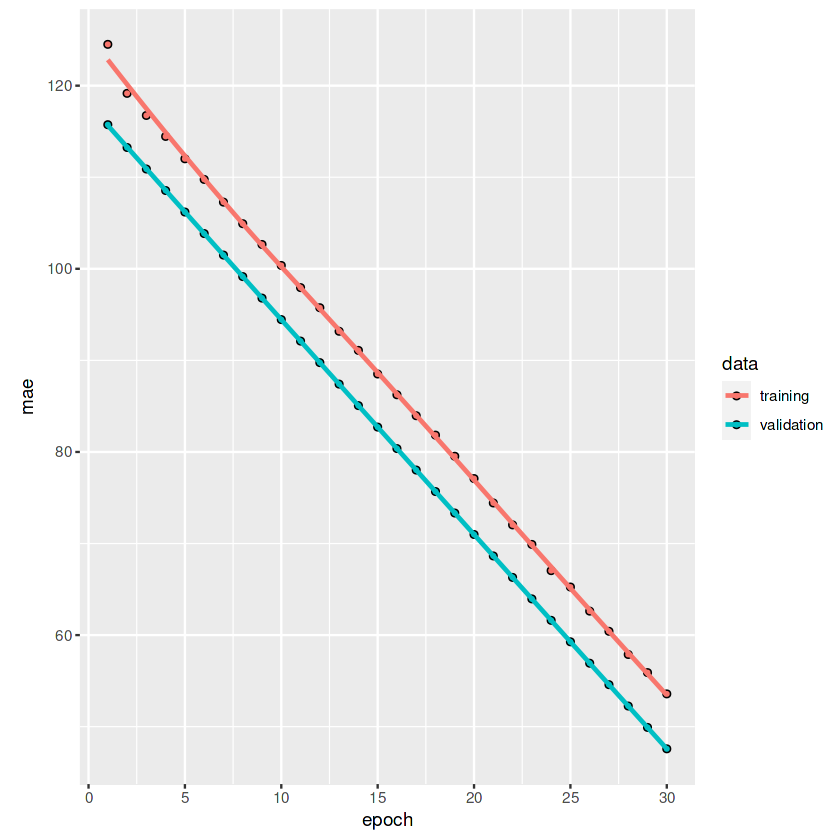

In [71]:
plot(history_gru_jy, metrics = "mae")

Model GRU do przewidywania kursu jena japońskiego pokazuje systematyczne zmniejszanie się MAE dla zbioru treningowego i walidacyjnego w trakcie 30 epok. MAE dla obu zbiorów maleje w sposób liniowy, co może wskazywać na systematyczne uczenie się modelu bez widocznych oznak nadmiernego dopasowania. Niemniej jednak, ostateczne MAE na zbiorze testowym wynosi 56.45429, co jest bardzo wysoką wartością w porównaniu do modelu bazowego (1.885314). Sugeruje to, że model GRU jest nieodpowiednio dostrojony lub nieodpowiedni dla tego konkretnego zadania, ponieważ osiąga znacznie gorsze wyniki w porównaniu do prostszego modelu bazowego.

In [27]:
#Trening dla Korean.won.
history_gru_kw<-train_model(model_gru_kw, train_dataset_kw, val_dataset_kw)

In [28]:
evaluate_gru_kw<-evaluate_model(model_gru_kw, test_dataset_kw)

cat("Test MAE dla Korean.won.:", evaluate_gru_kw[["mae"]])

Test MAE dla Korean.won.: 1268.621

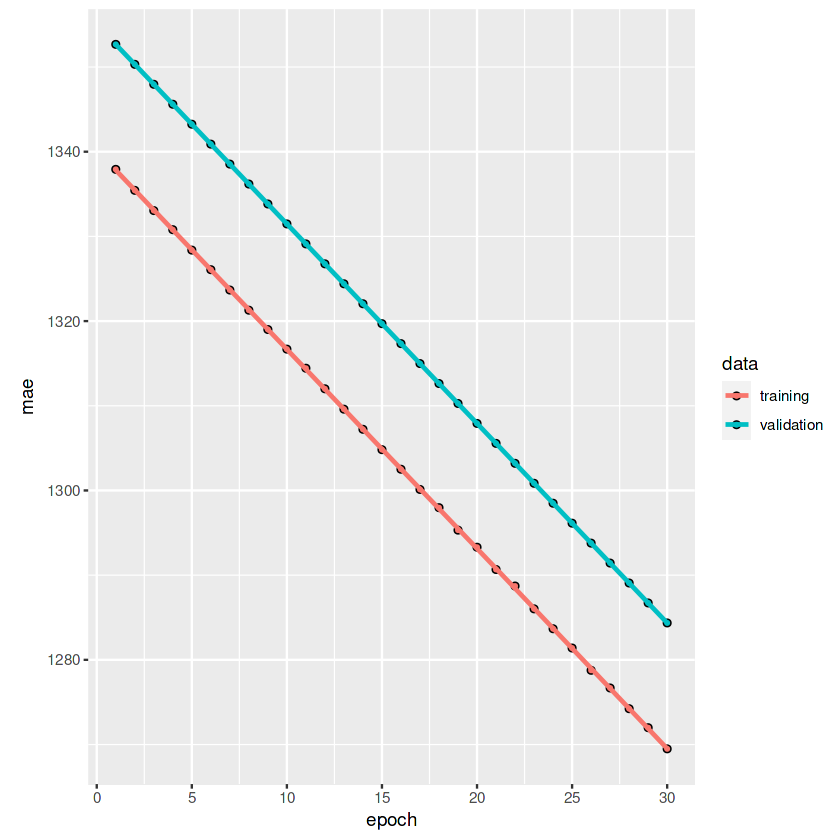

In [29]:
plot(history_gru_kw, metrics = "mae")

Model GRU do przewidywania kursu wona koreańskiego pokazuje, że MAE zarówno dla zbioru treningowego, jak i walidacyjnego, systematycznie maleje w miarę wzrostu liczby epok. Historia uczenia pokazuje, że MAE dla zbioru walidacyjnego jest stale wyższe niż dla zbioru treningowego, co może świadczyć o przeuczeniu modelu. Końcowy Test MAE dla modelu wynosi 1268.621, co jest znacząco wyższe niż MAE modelu bazowego (16.74426). Sugeruje to, że mimo poprawy podczas treningu, model GRU nie jest skuteczny i jego wydajność jest znacznie gorsza od modelu bazowego.

## Podsumowanie
Żaden z testowanych modeli sieci neuronowych nie przewyższył skutecznością modelu bazowego. Wyniki wskazują, że modele LSTM i 1D CNN osiągają zbliżoną skuteczność i dają najlepsze wyniki w prognozowaniu kursów walut. Oznacza to, że choć obecnie nie przewyższają modelu bazowego, posiadają potencjał do dalszego rozwoju i poprawy.

Model LSTM szczególnie wyróżnia się brakiem przeuczenia w porównaniu do innych modeli, co świadczy o jego zdolności do efektywnego uczenia się na różnych zestawach danych. Model GRU osiągał wyniki średnie, z niewielkim ryzykiem przeuczenia, natomiast sieć gęsta wykazała się najgorszą zdolnością do generalizacji, co mogło prowadzić do wysokich błędów na danych testowych.

